In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import neurokit as nk
import seaborn as sns
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import kurtosis, skew
from scipy.signal import find_peaks

from sktime.regression.deep_learning import CNNRegressor
from sktime.forecasting.model_selection import temporal_train_test_split
from statsmodels.tsa.vector_ar.var_model import VAR
from math import sqrt

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.kernel_based import RocketClassifier

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.inspection import (partial_dependence, PartialDependenceDisplay, permutation_importance)
from sklearn import preprocessing, datasets, ensemble, model_selection
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# Criação de dataset unificado

In [2]:
data_set_path = r"C:\Users\luiza\Documents\UFSC\TCC_Datasets\WESAD\WESAD"


In [3]:
# Lista para armazenar os dados combinados de todos os diretórios
all_data = []

# Lista de diretórios de S2 a S17
folders = [f"S{i}" for i in range(2, 18)]

for folder_name in folders:
    folder_path = os.path.join(data_set_path, folder_name)

    if os.path.exists(folder_path):
        for folder in os.listdir(folder_path):
            if folder.endswith(".pkl"):
                caminho_arquivo_pkl = os.path.join(folder_path, folder)
                
                # Abrir o arquivo .pkl
                with open(caminho_arquivo_pkl, 'rb') as infile:
                    obj = pickle.load(infile, encoding='latin1')
                    bvp=obj['signal']['wrist']['BVP'][:,0]
                    eda=obj['signal']['wrist']['EDA'][:,0]
                    temp=obj['signal']['wrist']['TEMP'][:,0]
                    label=obj['label']



In [4]:
fs_label = 700  # Hz
fs_temp_eda = 4  # Hz
fs_bvp = 64  # Hz

len_label = len(label)
len_temp_eda = len(temp)
len_bvp = len(bvp)

total_time = len_label / fs_label

time_label = np.linspace(0, total_time, len_label, endpoint=False)
time_temp_eda = np.linspace(0, total_time, len_temp_eda, endpoint=False)
time_bvp = np.linspace(0, total_time, len_bvp, endpoint=False)


interp_temp = interp1d(time_temp_eda, temp, kind='nearest', fill_value='extrapolate')
interp_eda = interp1d(time_temp_eda, eda, kind='nearest', fill_value='extrapolate')
interp_bvp = interp1d(time_bvp, bvp, kind='nearest', fill_value='extrapolate')

aligned_temp = interp_temp(time_label)
aligned_eda = interp_eda(time_label)
aligned_bvp = interp_bvp(time_label)

In [5]:
hr_data = []
folders = [f"S{i}" for i in range(2, 18)]


for folder_name in folders:
    subfolder_name = f"{folder_name}_E4_Data"
    folder_path = os.path.join(data_set_path, folder_name, subfolder_name)

    if os.path.exists(folder_path):
        csv_path = os.path.join(folder_path, 'HR.csv')
        if os.path.exists(csv_path):
            hr = pd.read_csv(csv_path, skiprows=2, usecols=[0], header=None)
            hr_data.append(hr)

if hr_data:
    combined_hr_df = pd.concat(hr_data, ignore_index=True)
    # Converte para numpy array
    hr = combined_hr_df.iloc[:, 0].to_numpy()

fs_hr = 1  # Hz
len_hr = len(hr)
time_hr = np.linspace(0, total_time, len_hr, endpoint=False)
interp_hr = interp1d(time_hr, hr, kind='nearest', fill_value='extrapolate')
aligned_hr = interp_hr(time_label)

In [6]:
numpy_data = np.column_stack((aligned_bvp, aligned_hr, aligned_eda, aligned_temp, label))
all_data.append(numpy_data)
combined_data = np.concatenate(all_data, axis=0)
column_names = ["bvp", "hr", "eda", "temp", "label"]
df = pd.DataFrame(data=combined_data, columns=column_names)

# 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation, 5/6/7 = should be ignored in this dataset 
df = df[df['label'] != 7.0]
df= df[df['label'] != 6.0]
df= df[df['label'] != 5.0]
df = df.drop_duplicates()

In [7]:
df

bvp      hr       eda   temp  label
0       -0.49  101.00  2.015176  33.39    0.0
6       -0.38  101.00  2.015176  33.39    0.0
17      -0.36  101.00  2.015176  33.39    0.0
20      -0.36  106.50  2.015176  33.39    0.0
28      -0.75  106.50  2.015176  33.39    0.0
...       ...     ...       ...    ...    ...
4143942 -2.09   73.65  0.783331  31.81    0.0
4143951 -3.28   73.65  0.783331  31.81    0.0
4143962 -4.43   73.65  0.783331  31.81    0.0
4143973 -5.44   73.65  0.783331  31.81    0.0
4143984 -6.21   73.65  0.783331  31.81    0.0

[476726 rows x 5 columns]

### NORMALIZAR E CRIAR MIN, MEAN, MAX

In [8]:
def calculate_and_normalize_stats(df, column):
    min_vals, max_vals, mean_vals = [], [], []
    for i in range(0, len(df), 3):
        vals = df[column].iloc[i:i+3]
        min_vals.append(vals.min())
        max_vals.append(vals.max())
        mean_vals.append(vals.mean())
    stats_df = pd.DataFrame({f'{column}_min': min_vals, f'{column}_max': max_vals, f'{column}_mean': mean_vals})
    normalized_mean = preprocessing.normalize([stats_df[f'{column}_mean'].to_numpy()]).flatten()
    normalized_max = preprocessing.normalize([stats_df[f'{column}_max'].to_numpy()]).flatten()
    normalized_min = preprocessing.normalize([stats_df[f'{column}_min'].to_numpy()]).flatten()
    return pd.DataFrame({f'normalized_{column}_mean': normalized_mean,
                        f'normalized_{column}_max': normalized_max,
                        f'normalized_{column}_min': normalized_min})

# Calcular e normalizar estatísticas para temperatura, EDA e HR
df_temp = calculate_and_normalize_stats(df, 'temp')
df_eda = calculate_and_normalize_stats(df, 'eda')
df_hr = calculate_and_normalize_stats(df, 'hr')

# Combinar os dataframes normalizados
df_normalizado = pd.concat([df_temp, df_eda, df_hr], axis=1)
df_normalizado.tail()

normalized_temp_mean  normalized_temp_max  normalized_temp_min  \
158904               0.00244              0.00244              0.00244   
158905               0.00244              0.00244              0.00244   
158906               0.00244              0.00244              0.00244   
158907               0.00244              0.00244              0.00244   
158908               0.00244              0.00244              0.00244   

        normalized_eda_mean  normalized_eda_max  normalized_eda_min  \
158904             0.001766            0.001765            0.001766   
158905             0.001766            0.001765            0.001766   
158906             0.001766            0.001765            0.001766   
158907             0.001766            0.001765            0.001766   
158908             0.001766            0.001765            0.001766   

        normalized_hr_mean  normalized_hr_max  normalized_hr_min  
158904            0.002401           0.002400           0.002402  
158905            0.002394           0.002400           0.002391  
158906            0.002390           0.002389           0.002391  
158907            0.002378           0.002376           0.002379  
158908            0.002378           0.002376           0.002379

In [9]:
label_mean = []
for i in range(0, len(df), 3):
    label = df['label'].iloc[i:i+3] 
    label_mean.append(label.mean())

label_stats = pd.DataFrame({'label_mean': label_mean})

# Aplicando algoritmos de classificação

In [10]:
train_set = df_normalizado
labels = np.array(label_stats, dtype=int)
X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.3, random_state=30)

In [11]:
if len(y_train.shape) > 1:
    y_train = y_train.flatten()
y_train_series = pd.Series(y_train)
y_train_series.value_counts()

0    53132
1    22752
4    14144
2    13996
3     7212
dtype: int64

### knn

In [12]:
k_nearest_neighbors = KNeighborsClassifier(n_neighbors=5, metric="minkowski", weights="uniform")
k_nearest_neighbors.fit(X_train, y_train.ravel())
y_pred_knn = k_nearest_neighbors.predict(X_test)
f1score_knn = f1_score(y_test, y_pred_knn, average='macro')
recall_knn = recall_score(y_test, y_pred_knn, average='macro')
accuracy_knn = accuracy_score(y_test, y_pred_knn)
AUC_knn = roc_auc_score(y_test.ravel(), k_nearest_neighbors.predict_proba(X_test), multi_class='ovr')

print('KNN - auc =', AUC_knn)
print('KNN - acc =', accuracy_knn)
print('KNN - f1 =', f1score_knn)
print('KNN - recall =', recall_knn)

KNN - auc = 0.991591047189687
KNN - acc = 0.9490067753235584
KNN - f1 = 0.9442958738494482
KNN - recall = 0.9461815087771754


### Logistic Regression

In [13]:
logistic_regression = LogisticRegression(penalty="l2", C=1.0, max_iter=999)
logistic_regression.fit(X_train, y_train.ravel())

y_pred_lr = logistic_regression.predict(X_test)
f1score_lr = f1_score(y_test, y_pred_lr, average='macro')
recall_lr = recall_score(y_test, y_pred_lr, average='macro')
accuracy_lr = accuracy_score(y_test, y_pred_lr)
AUC_lr = roc_auc_score(y_test.ravel(), logistic_regression.predict_proba(X_test), multi_class='ovr')

print('LR - auc =', AUC_lr)
print('LR - acc =', accuracy_lr)
print('LR - f1 =', f1score_lr)
print('LR - recall =', recall_lr)

LR - auc = 0.7752635523657919
LR - acc = 0.47582489039917775
LR - f1 = 0.12896513495458875
LR - recall = 0.2


### RF

In [14]:
clf = RandomForestClassifier(n_estimators=100,max_depth=15)
clf.fit(X_train, y_train.ravel())
y_pred_rf = clf.predict(X_test)

f1score_rf = f1_score(y_test, y_pred_rf, average='macro')
recall_rf = recall_score(y_test, y_pred_rf, average='macro')
accuracy_rf = accuracy_score(y_test, y_pred_rf)
AUC_rf = roc_auc_score(y_test.ravel(), clf.predict_proba(X_test), multi_class='ovr')

print('RF - auc =', AUC_rf)
print('RF - acc =', accuracy_rf)
print('RF - f1 =', f1score_rf)
print('RF - recall =', recall_rf)

RF - auc = 0.9995768305913755
RF - acc = 0.9832190128584314
RF - f1 = 0.98186156679384
RF - recall = 0.9833715632996828


### neural network

In [15]:
neural_network = MLPClassifier(hidden_layer_sizes=(100,), activation="relu", solver="adam", max_iter=999)

neural_network.fit(X_train, y_train.ravel())

y_pred_nn = neural_network.predict(X_test)
f1score_nn = f1_score(y_test, y_pred_nn, average='macro')
recall_nn = recall_score(y_test, y_pred_nn, average='macro')
accuracy_nn = accuracy_score(y_test, y_pred_nn)
AUC_nn = roc_auc_score(y_test.ravel(), neural_network.predict_proba(X_test), multi_class='ovr')

print('NN - auc =', AUC_nn)
print('NN - acc =', accuracy_nn)
print('NN - f1 =', f1score_nn)
print('NN - recall =', recall_nn)

c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.
  warnings.warn(


NN - auc = 0.9205283075713036
NN - acc = 0.6393975625616177
NN - f1 = 0.3731815717573894
NN - recall = 0.3912078455565982


### SVM

In [16]:
support_vector_machine = SVC(C=1.0, gamma=0.1, kernel="linear", tol=0.001, max_iter=9999, probability=True)
support_vector_machine.fit(X_train, y_train.ravel())
y_pred_svm = support_vector_machine.predict(X_test)

f1score_svm = f1_score(y_test, y_pred_svm, average='macro')
recall_svm = recall_score(y_test, y_pred_svm, average='macro')
accuracy_svm = accuracy_score(y_test, y_pred_svm)
AUC_svm = roc_auc_score(y_test.ravel(), support_vector_machine.predict_proba(X_test), multi_class='ovr')

print('SVM - auc =', AUC_svm)
print('SVM - acc =', accuracy_svm)
print('SVM - f1 =', f1score_svm)
print('SVM - recall =', recall_svm)

c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=9999).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM - auc = 0.8142701371653851
SVM - acc = 0.3615044154972416
SVM - f1 = 0.2956723635708373
SVM - recall = 0.3939929898922237


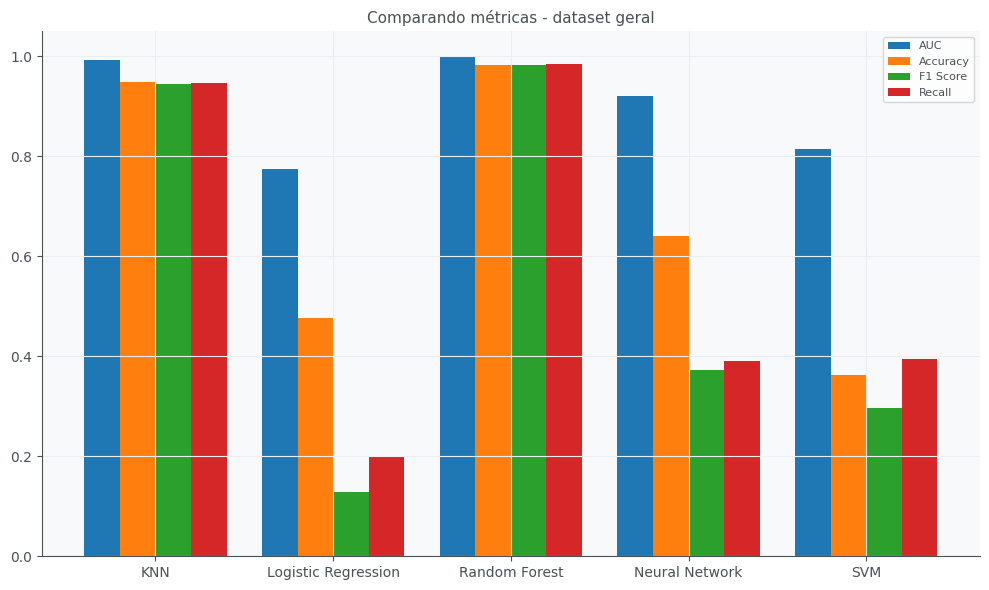

In [17]:

labels = ['KNN', 'Logistic Regression', 'Random Forest', 'Neural Network', 'SVM']
auc_scores = [AUC_knn, AUC_lr, AUC_rf, AUC_nn, AUC_svm]
accuracy_scores = [accuracy_knn, accuracy_lr, accuracy_rf, accuracy_nn, accuracy_svm]
f1_scores = [f1score_knn, f1score_lr, f1score_rf, f1score_nn, f1score_svm]
recall_scores = [recall_knn, recall_lr, recall_rf, recall_nn, recall_svm]

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(labels))

ax.bar(x - 0.3, auc_scores, width=0.2, label='AUC')
ax.bar(x - 0.1, accuracy_scores, width=0.2, label='Accuracy')
ax.bar(x + 0.1, f1_scores, width=0.2, label='F1 Score')
ax.bar(x + 0.3, recall_scores, width=0.2, label='Recall')

ax.set_title('Comparando métricas - dataset geral')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()

### feature importance

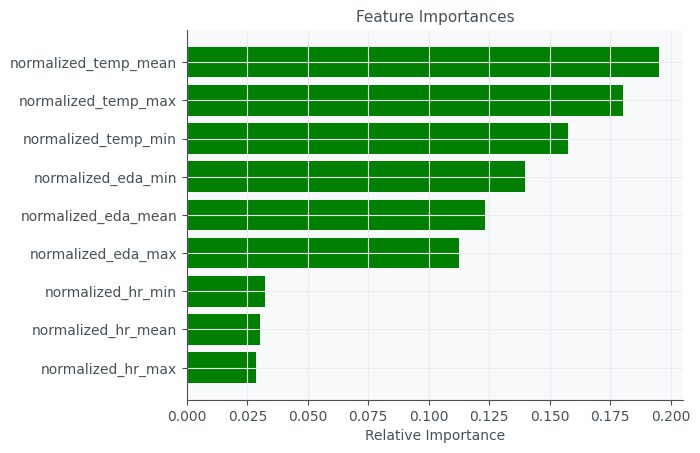

In [18]:
# -- feature importance graph
importances = clf.feature_importances_
indices = np.argsort(importances)
features = train_set.columns
plt.title('Feature Importances')
j = 9   # top j importance
plt.barh(range(j), importances[indices][len(indices)-j:], color='g', align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.xlabel('Relative Importance')
plt.show()

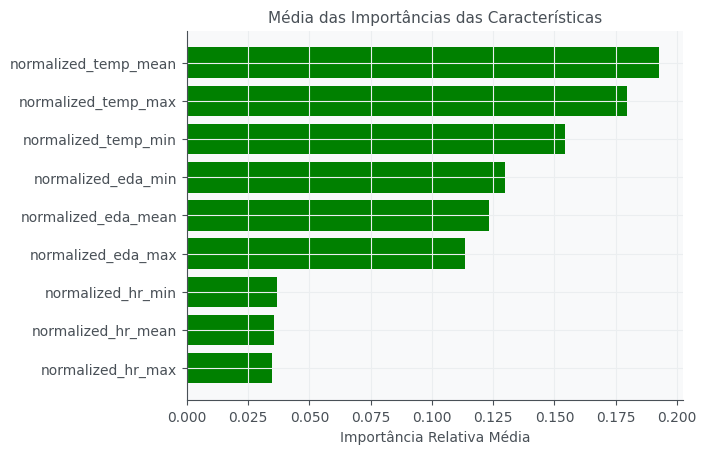

In [19]:
num_execucoes = 100
importancias_medias = np.zeros(X_train.shape[1])  # Lista para armazenar as importâncias médias das características

for _ in range(num_execucoes):
    clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=None) 
    clf.fit(X_train, y_train.ravel()) 
    
    importancias = clf.feature_importances_
    importancias_medias += importancias

importancias_medias /= num_execucoes # Calcular a média das importâncias das características

indices = np.argsort(importancias_medias)
plt.title('Média das Importâncias das Características')
j = 9   # top j importância
plt.barh(range(j), importancias_medias[indices][len(indices)-j:], color='g', align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.xlabel('Importância Relativa Média')
plt.show()

In [20]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train.ravel())
clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)
y_pred_rf = clf.predict(X_test)

f1score_rf = f1_score(y_test, y_pred_rf, average='macro')
recall_rf = recall_score(y_test, y_pred_rf, average='macro')
accuracy_rf = accuracy_score(y_test, y_pred_rf)
AUC_rf = roc_auc_score(y_test.ravel(), clf.predict_proba(X_test), multi_class='ovr')

print('RF - AUC =', AUC_rf)
print('RF - Accuracy =', accuracy_rf)
print('RF - F1 Score =', f1score_rf)
print('RF - Recall =', recall_rf)


RF - AUC = 0.9991509449636464
RF - Accuracy = 0.9638579489438466
RF - F1 Score = 0.9571136841651583
RF - Recall = 0.9827734434844373


# Criação de datasets individuais

In [21]:
dfs = {}
folders = [f"S{i}" for i in range(2, 18)]

for folder_name in folders:
    folder_path = os.path.join(data_set_path, folder_name)
    
    user_data = []

    if os.path.exists(folder_path):
        for folder in os.listdir(folder_path):
            if folder.endswith(".pkl"):
                caminho_arquivo_pkl = os.path.join(folder_path, folder)
                
                # Abrir o arquivo .pkl
                with open(caminho_arquivo_pkl, 'rb') as infile:
                    obj = pickle.load(infile, encoding='latin1')
                    eda = obj['signal']['wrist']['EDA'][:, 0]
                    temp = obj['signal']['wrist']['TEMP'][:, 0]
                    label = obj['label']

                    len_label = len(label)
                    len_temp_eda = len(temp)

                    total_time = len_label / fs_label

                    time_label = np.linspace(0, total_time, len_label, endpoint=False)
                    time_temp_eda = np.linspace(0, total_time, len_temp_eda, endpoint=False)

                    interp_temp = interp1d(time_temp_eda, temp, kind='nearest', fill_value='extrapolate')
                    interp_eda = interp1d(time_temp_eda, eda, kind='nearest', fill_value='extrapolate')

                    aligned_temp = interp_temp(time_label)
                    aligned_eda = interp_eda(time_label)

                    user_data.append((aligned_eda, aligned_temp, label))

    hr_data = []
    subfolder_name = f"{folder_name}_E4_Data"
    folder_path = os.path.join(data_set_path, folder_name, subfolder_name)

    if os.path.exists(folder_path):
        csv_path = os.path.join(folder_path, 'HR.csv')
        if os.path.exists(csv_path):
            hr = pd.read_csv(csv_path, skiprows=2, usecols=[0], header=None)
            hr_data.append(hr)

    if hr_data:
        combined_hr_df = pd.concat(hr_data, ignore_index=True)
        hr = combined_hr_df.iloc[:, 0].to_numpy()

        len_hr = len(hr)
        time_hr = np.linspace(0, total_time, len_hr, endpoint=False)
        interp_hr = interp1d(time_hr, hr, kind='nearest', fill_value='extrapolate')
        aligned_hr = interp_hr(time_label)

        for eda, temp, label in user_data:
            numpy_data = np.column_stack((aligned_hr, eda, temp, label))
            if folder_name not in dfs:
                dfs[folder_name] = []
            dfs[folder_name].append(numpy_data)

for key in dfs:
    combined_data = np.concatenate(dfs[key], axis=0)
    column_names = ["hr", "eda", "temp", "label"]
    df = pd.DataFrame(data=combined_data, columns=column_names)
    
    df = df[df['label'] != 7.0]
    df = df[df['label'] != 6.0]
    df = df[df['label'] != 5.0]
    df = df.drop_duplicates()
    
    df_temp = calculate_and_normalize_stats(df, 'temp')
    df_eda = calculate_and_normalize_stats(df, 'eda')
    df_hr = calculate_and_normalize_stats(df, 'hr')

    df_normalizado = pd.concat([df_temp, df_eda, df_hr], axis=1)
    
    label_mean = []
    for i in range(0, len(df), 3):
        label = df['label'].iloc[i:i+3] 
        label_mean.append(label.mean())
    label_stats = pd.DataFrame({'label_mean': label_mean})

    dfs[key] = pd.concat([df_normalizado, label_stats], axis=1)
    dfs[key] = dfs[key].drop_duplicates()

for i in list(range(2, 12)) + list(range(13, 18)):
    globals()[f'dfs{i}'] = dfs[f'S{i}']

In [22]:
for i in list(range(2, 12)) + list(range(13, 18)):
    dataset_name = f'dfs{i}'
    if dataset_name in globals():
        df = globals()[dataset_name]
        print(f'Tamanho do dataset {dataset_name}: {len(df)} linhas')

Tamanho do dataset dfs2: 7942 linhas
Tamanho do dataset dfs3: 8060 linhas
Tamanho do dataset dfs4: 7746 linhas
Tamanho do dataset dfs5: 8989 linhas
Tamanho do dataset dfs6: 10557 linhas
Tamanho do dataset dfs7: 8094 linhas
Tamanho do dataset dfs8: 6808 linhas
Tamanho do dataset dfs9: 6764 linhas
Tamanho do dataset dfs10: 7314 linhas
Tamanho do dataset dfs11: 7744 linhas
Tamanho do dataset dfs13: 8773 linhas
Tamanho do dataset dfs14: 6398 linhas
Tamanho do dataset dfs15: 6960 linhas
Tamanho do dataset dfs16: 7401 linhas
Tamanho do dataset dfs17: 8338 linhas


In [23]:
datasets = [globals()[f'dfs{i}'] for i in range(2, 18) if i != 12]

for i, dfs in enumerate(datasets, start=2):
    if i == 12:
        continue

    X = dfs.drop(columns=["label_mean"]) 
    y = dfs["label_mean"].astype(int)

    X_train_skt, X_test_skt, y_train_skt, y_test_skt = temporal_train_test_split(X, y, test_size=0.2)

    X_train_array = X_train_skt.values
    X_test_array = X_test_skt.values

    print(f"Dataset dfs{i}:")
    print(y_train_skt.value_counts())
    print("-" * 30)

Dataset dfs2:
0    3503
1    1448
2     935
4     438
3      29
Name: label_mean, dtype: int64
------------------------------
Dataset dfs3:
0    3470
1    1537
2    1009
4     390
3      42
Name: label_mean, dtype: int64
------------------------------
Dataset dfs4:
0    3066
1    1225
2    1071
4     431
3     403
Name: label_mean, dtype: int64
------------------------------
Dataset dfs5:
0    3410
1    1639
2    1079
3     533
4     530
Name: label_mean, dtype: int64
------------------------------
Dataset dfs6:
0    5155
1    1497
2    1090
4     531
3     172
Name: label_mean, dtype: int64
------------------------------
Dataset dfs7:
0    2363
1    1851
2    1094
4     584
3     583
Name: label_mean, dtype: int64
------------------------------
Dataset dfs8:
0    2168
1    1375
2    1036
4     452
3     415
Name: label_mean, dtype: int64
------------------------------
Dataset dfs9:
0    2462
1    1442
2     990
4     477
3      40
Name: label_mean, dtype: int64
-----------------------

### aplicando series temporais no s7


In [24]:
train_df = dfs7[:int(0.8*(len(dfs7)))]
test_df = dfs7[int(0.8*(len(dfs7))):]
data = pd.concat([train_df, test_df])

# Ajustar o modelo VAR
model = VAR(endog=train_df)
model_fit = model.fit()

# Fazer a previsão
steps = len(test_df)
forecast = model_fit.forecast(model_fit.endog, steps=steps)

# Converter previsões para DataFrame
pred_cols = train_df.columns
pred = pd.DataFrame(forecast, index=range(steps), columns=pred_cols)

# Calcular RMSE para cada coluna
for col in pred_cols:
    rmse = sqrt(mean_squared_error(test_df[col], pred[col]))
    print(f'rmse value for {col} is: {rmse}')

rmse value for normalized_temp_mean is: 0.0004932420640548757
rmse value for normalized_temp_max is: 0.0004928288887015375
rmse value for normalized_temp_min is: 0.0004936205602079761
rmse value for normalized_eda_mean is: 0.0036625821935947003
rmse value for normalized_eda_max is: 0.003691298421525587
rmse value for normalized_eda_min is: 0.0036338912691537928
rmse value for normalized_hr_mean is: 0.001518884518145487
rmse value for normalized_hr_max is: 0.0015226391842237065
rmse value for normalized_hr_min is: 0.001515565200448498
rmse value for label_mean is: 1.8019927268823943


rmse value for dfs2 normalized_temp_mean is: 0.00018854377460086384
rmse value for dfs2 normalized_temp_max is: 0.0001883707645063288
rmse value for dfs2 normalized_temp_min is: 0.00018867000530922238
rmse value for dfs2 normalized_eda_mean is: 0.0028266936563102105
rmse value for dfs2 normalized_eda_max is: 0.002896778442002241
rmse value for dfs2 normalized_eda_min is: 0.0027961526087201516
rmse value for dfs2 normalized_hr_mean is: 0.0015980516349765005
rmse value for dfs2 normalized_hr_max is: 0.001600294941235762
rmse value for dfs2 normalized_hr_min is: 0.0015956903324189193
rmse value for dfs2 label_mean is: 1.7641871596125118
rmse value for dfs3 normalized_temp_mean is: 0.0002839800800233125
rmse value for dfs3 normalized_temp_max is: 0.00028419046412084476
rmse value for dfs3 normalized_temp_min is: 0.0002837850840509746
rmse value for dfs3 normalized_eda_mean is: 0.004989508031931475
rmse value for dfs3 normalized_eda_max is: 0.004973904937417675
rmse value for dfs3 normalize

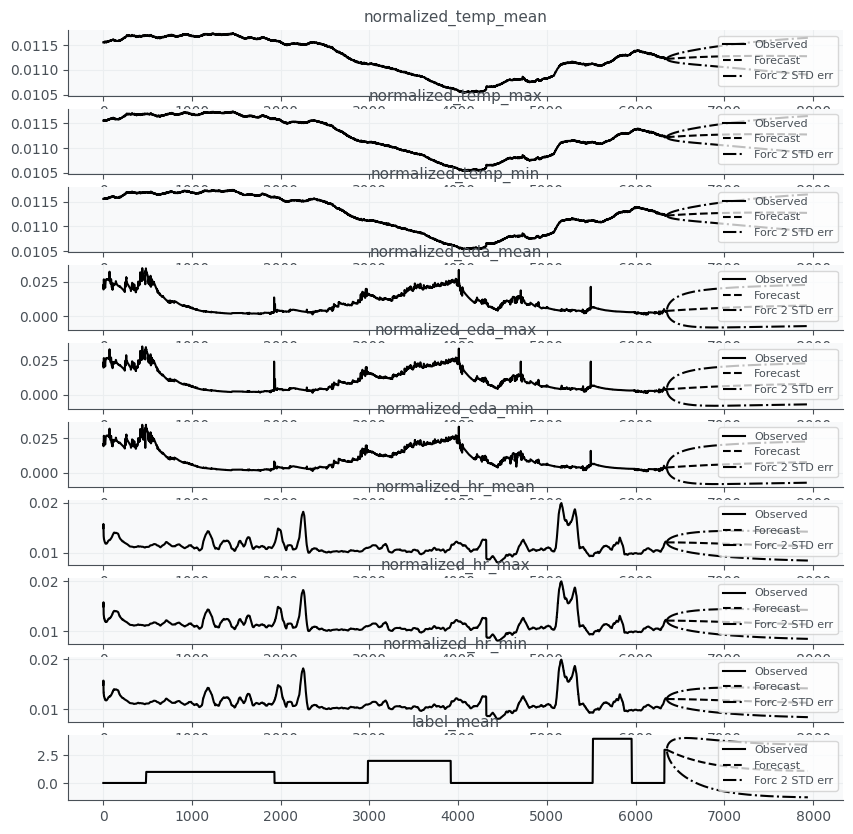

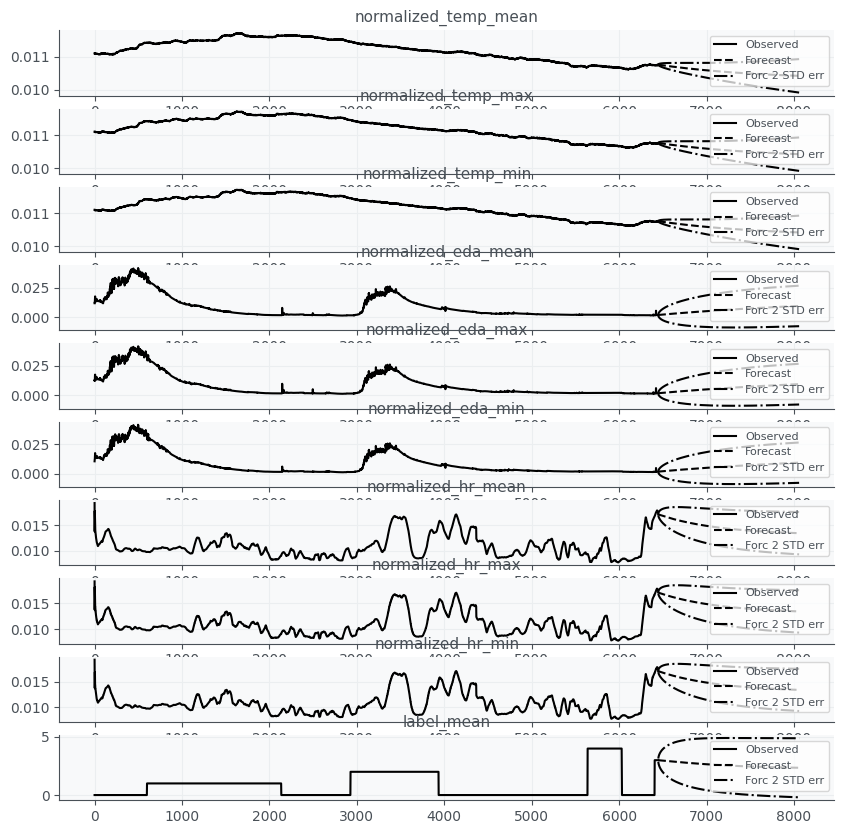

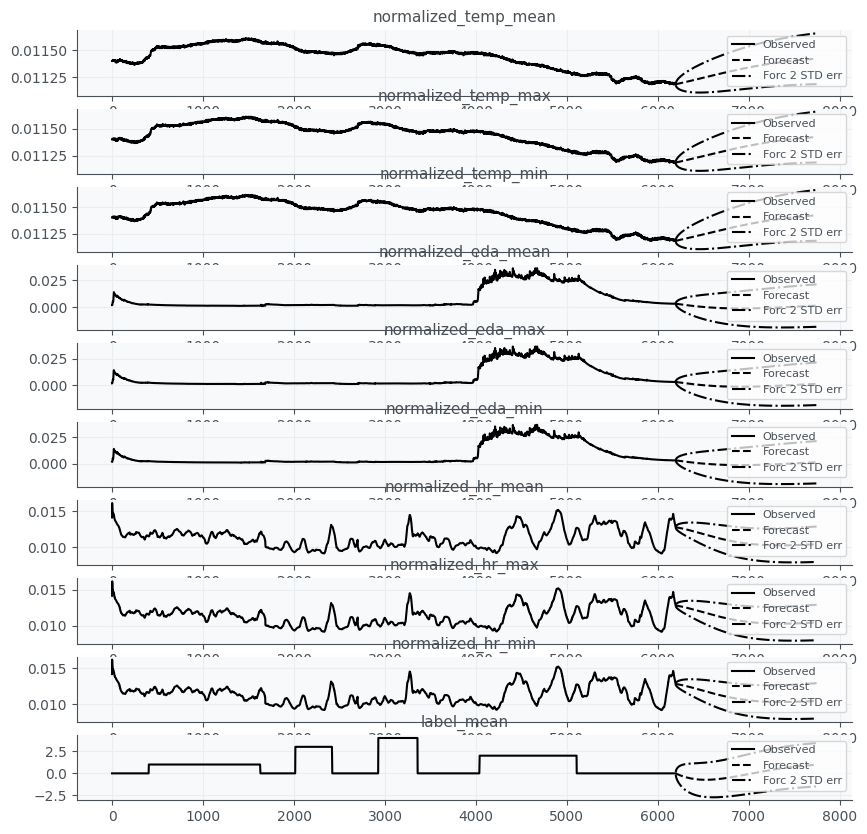

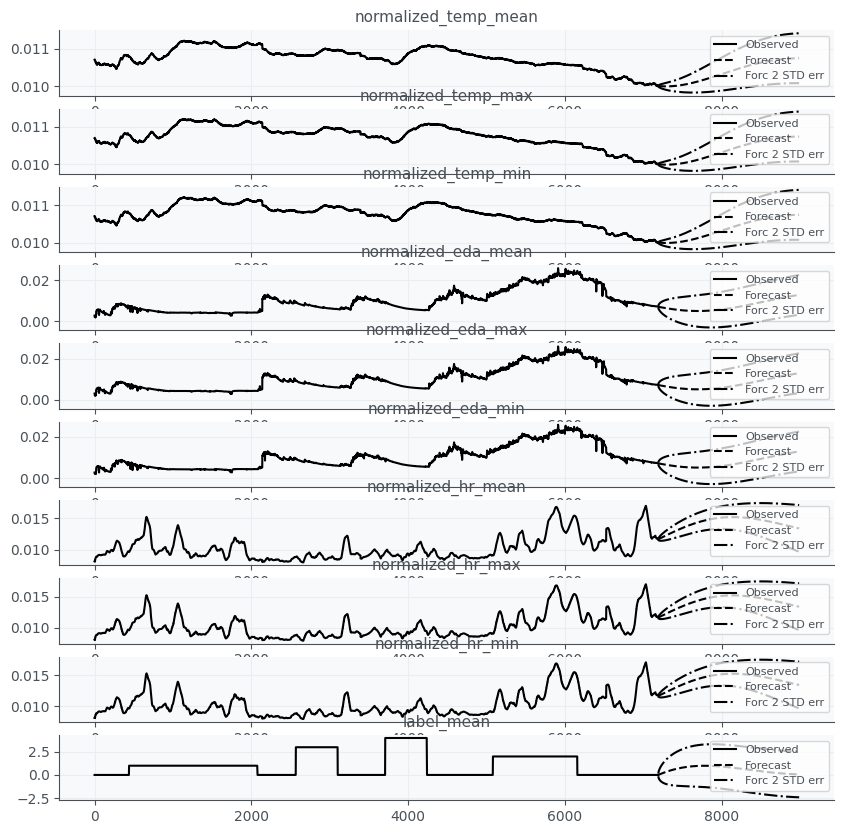

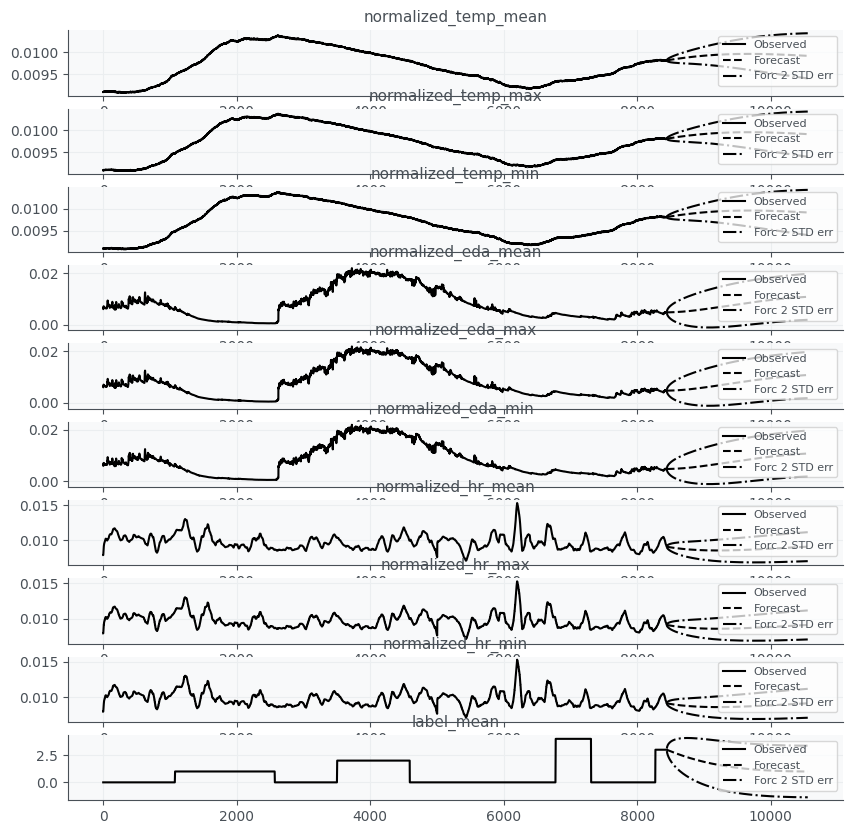

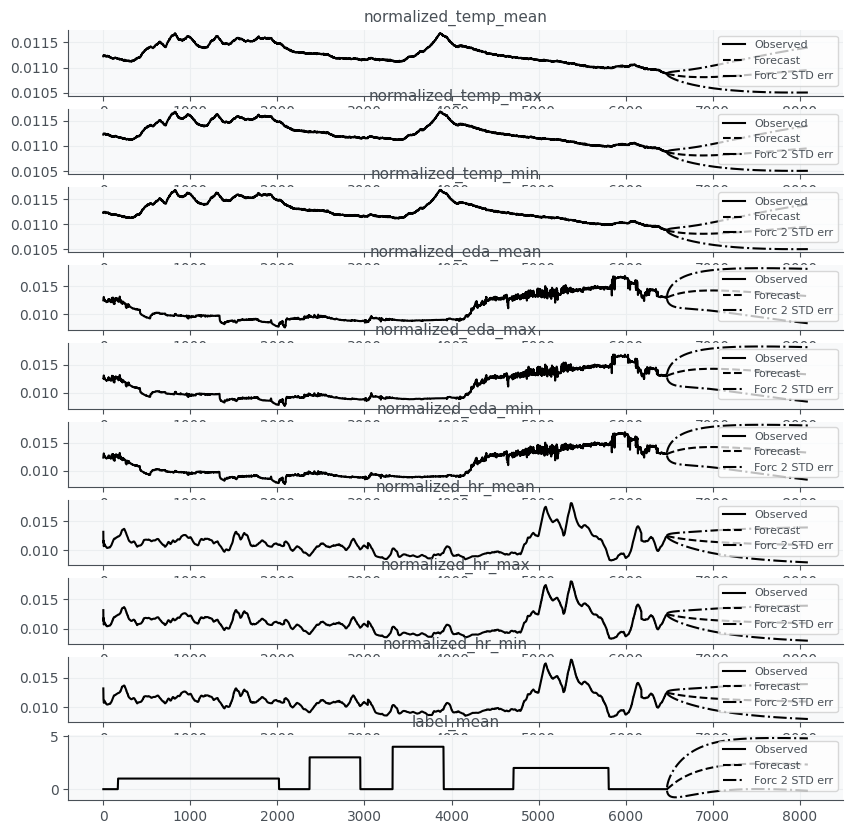

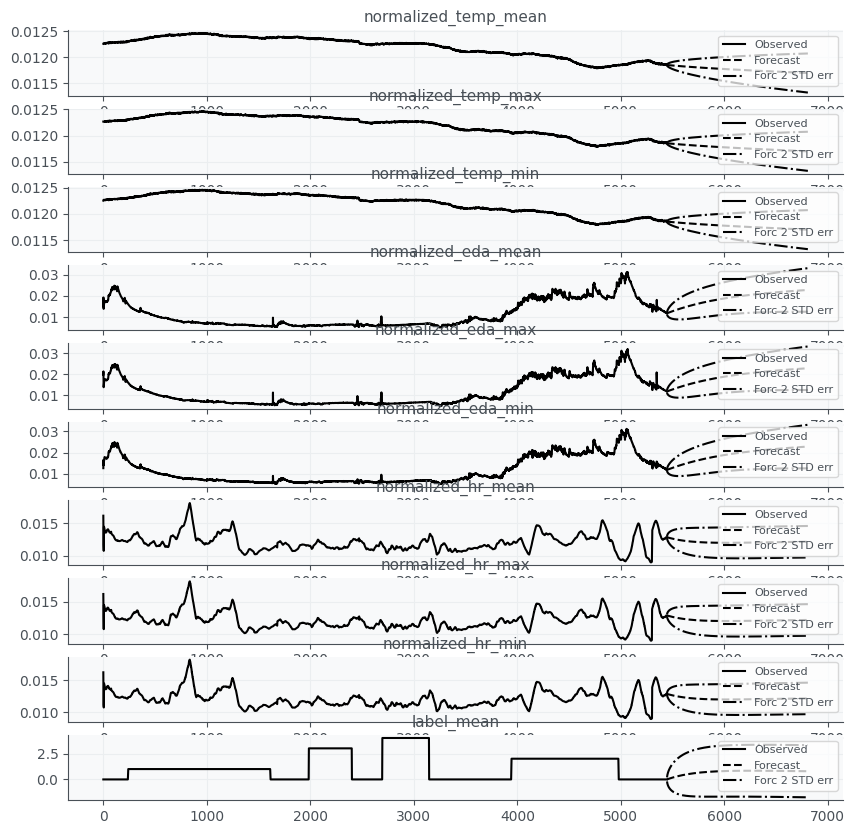

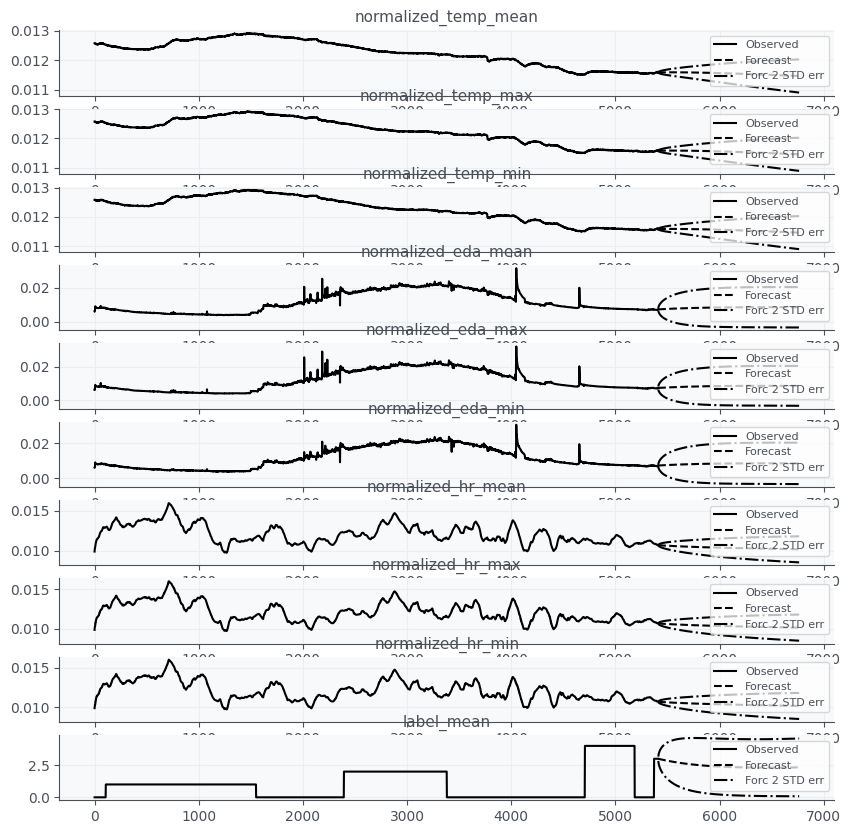

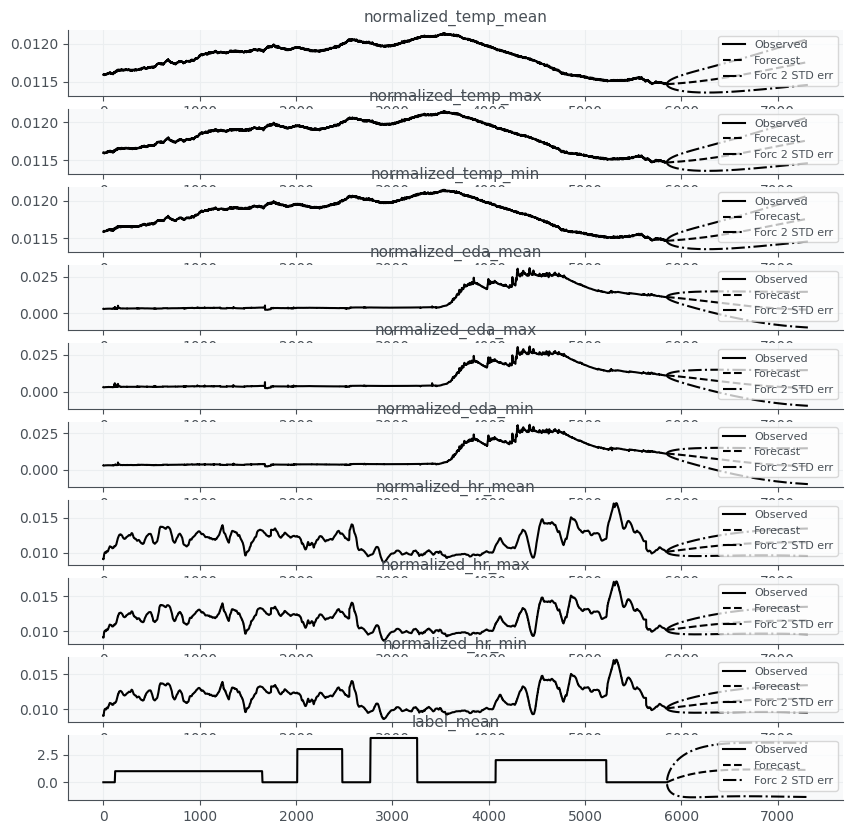

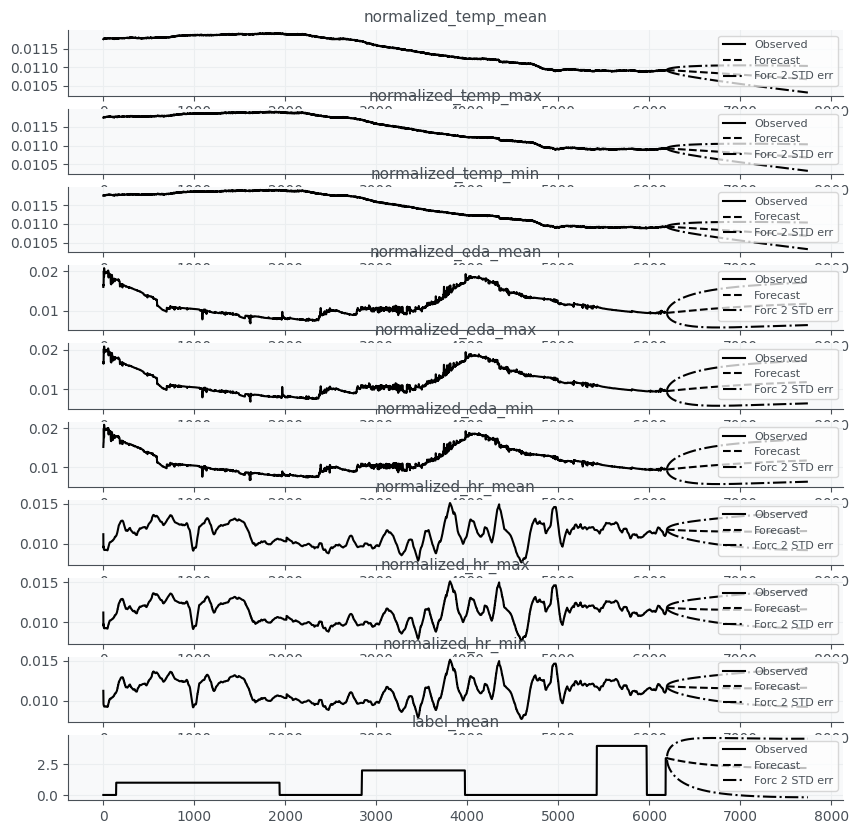

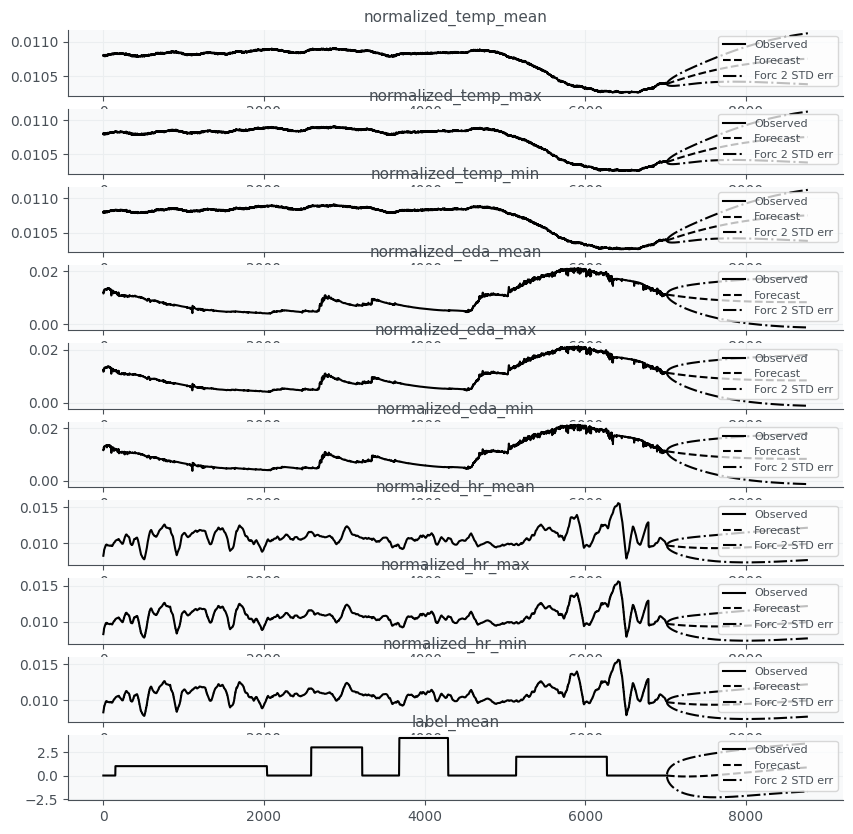

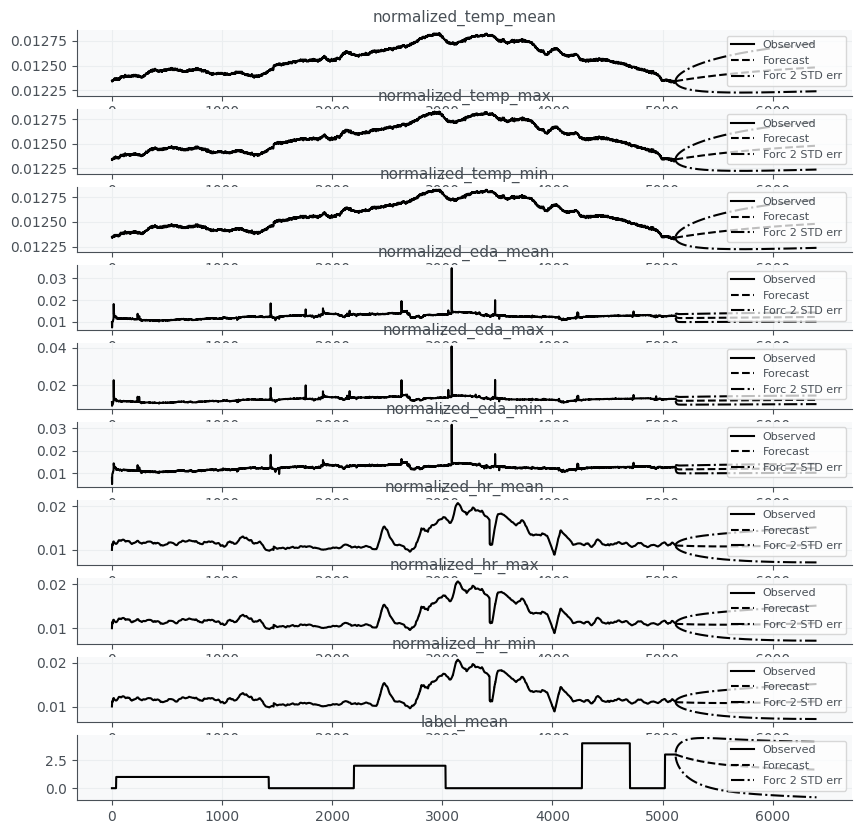

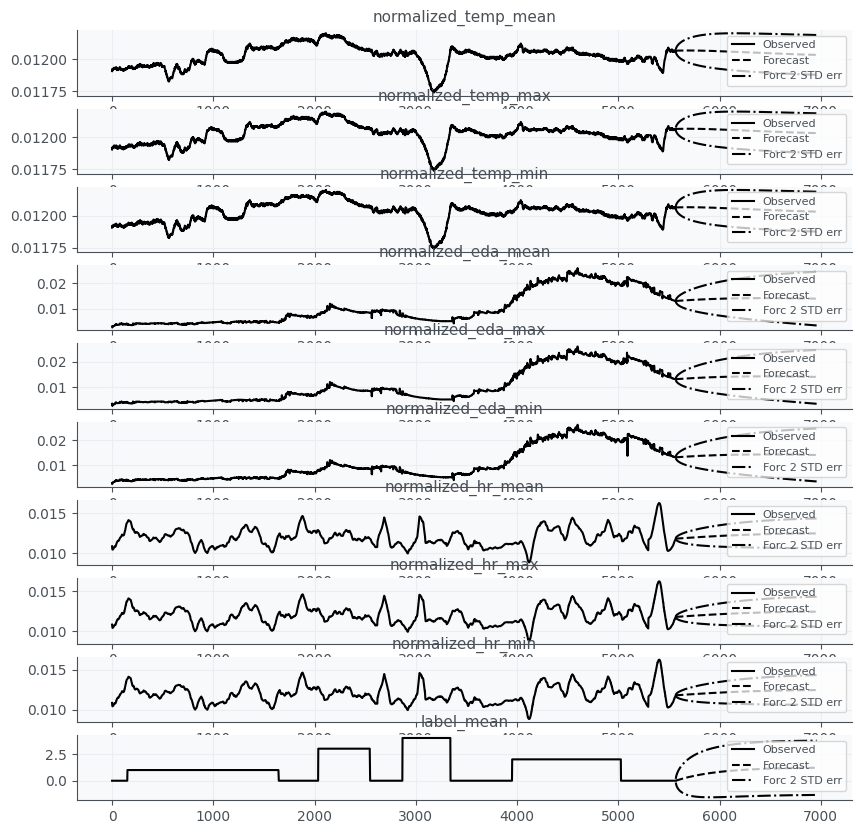

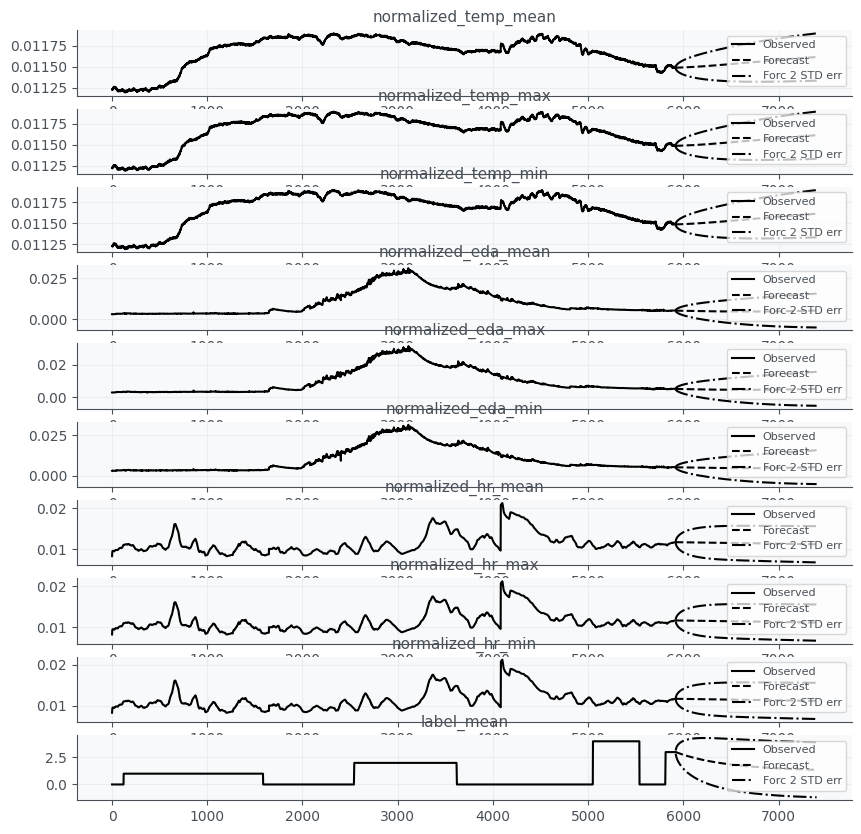

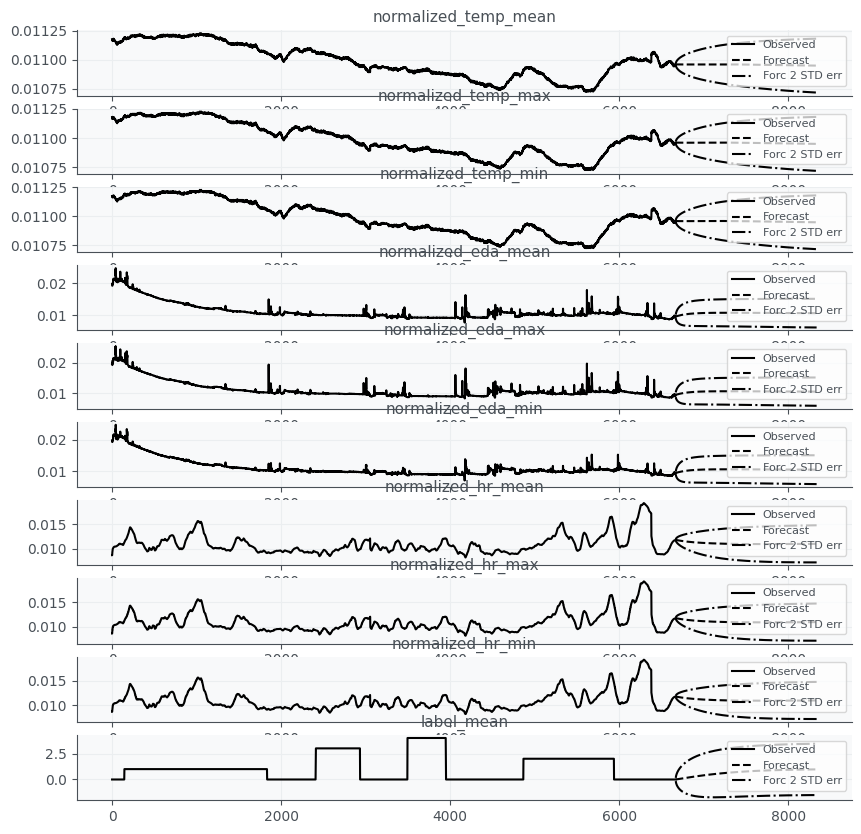

In [25]:
def plot_var_forc(prior, forc, err_upper, err_lower,
                index=None, names=None, plot_stderr=True,
                legend_options=None):
    import matplotlib.pyplot as plt

    n, k = prior.shape
    rows, cols = k, 1

    fig = plt.figure(figsize=(10, 10))

    prange = np.arange(n)
    rng_f = np.arange(n - 1, n + len(forc))
    rng_err = np.arange(n, n + len(forc))

    for j in range(k):
        ax = plt.subplot(rows, cols, j+1)

        p1 = ax.plot(prange, prior[:, j], 'k', label='Observed')
        p2 = ax.plot(rng_f, np.r_[prior[-1:, j], forc[:, j]], 'k--',
                    label='Forecast')

        if plot_stderr:
            p3 = ax.plot(rng_err, err_upper[:, j], 'k-.',
                        label='Forc 2 STD err')
            ax.plot(rng_err, err_lower[:, j], 'k-.')

        if names is not None:
            ax.set_title(names[j])

        if legend_options is None:
            legend_options = {"loc": "upper right"}
        ax.legend(**legend_options)
    return fig


dfs_list = [f'dfs{i}' for i in range(2, 18) if i != 12]


for df_name in dfs_list:
    try:
        df = globals()[df_name]
        
        train_df = df[:int(0.8 * len(df))]
        test_df = df[int(0.8 * len(df)):]
        
        model = VAR(endog=train_df)
        model_fit = model.fit()
        steps = len(test_df)
        forecast = model_fit.forecast(model_fit.endog, steps=steps)
        
        pred_cols = train_df.columns
        pred = pd.DataFrame(forecast, index=range(steps), columns=pred_cols)
        
        for col in pred_cols:
            rmse = sqrt(mean_squared_error(test_df[col], pred[col]))
            print(f'rmse value for {df_name} {col} is: {rmse}')

        Y = np.concatenate([train_df.values, test_df.values], axis=0)

        forecast_cov = model_fit.forecast_cov(steps=steps)
        err_upper = forecast + 2 * np.sqrt(np.diagonal(forecast_cov, axis1=1, axis2=2))
        err_lower = forecast - 2 * np.sqrt(np.diagonal(forecast_cov, axis1=1, axis2=2))
        plot_var_forc(train_df.values, forecast, err_upper, err_lower, index=df.index, names=pred_cols)    
    
    except KeyError:
        print(f"{df_name} does not exist.")

In [26]:
results = model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 05, Oct, 2024
Time:                     14:52:16
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -201.827
Nobs:                     6668.00    HQIC:                  -201.967
Log likelihood:           579200.    FPE:                1.79786e-88
AIC:                     -202.041    Det(Omega_mle):     1.74220e-88
--------------------------------------------------------------------
Results for equation normalized_temp_mean
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                           0.000013         0.000005            2.541           0.011
L1.normalized_temp_mean        -0.130735         0.073512           -1.778           0.075
L1.no

In [27]:
datasets = [f"dfs{i}" for i in range(2, 18) if i != 12]

for dataset_name in datasets:
    dfs = globals()[dataset_name]
    
    X = dfs.drop(columns=["label_mean"])
    y = dfs["label_mean"].astype(int)
    
    smote = SMOTE(random_state=47)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    X_train_skt, X_test_skt, y_train_skt, y_test_skt = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=47)
    
    X_train_array = X_train_skt.values
    X_test_array = X_test_skt.values

    print(f"\n{dataset_name}:")
    print("y_train_skt value counts:", y_train_skt.value_counts())


dfs2:
y_train_skt value counts: 2    2979
0    2959
3    2945
4    2944
1    2939
Name: label_mean, dtype: int64

dfs3:
y_train_skt value counts: 4    3048
3    3013
1    2997
0    2996
2    2989
Name: label_mean, dtype: int64

dfs4:
y_train_skt value counts: 0    2958
3    2954
2    2912
4    2907
1    2906
Name: label_mean, dtype: int64

dfs5:
y_train_skt value counts: 3    3308
1    3305
4    3304
2    3272
0    3243
Name: label_mean, dtype: int64

dfs6:
y_train_skt value counts: 1    4440
4    4408
2    4380
3    4368
0    4307
Name: label_mean, dtype: int64

dfs7:
y_train_skt value counts: 3    2402
2    2400
4    2395
1    2382
0    2352
Name: label_mean, dtype: int64

dfs8:
y_train_skt value counts: 4    2174
2    2167
1    2163
0    2157
3    2147
Name: label_mean, dtype: int64

dfs9:
y_train_skt value counts: 2    2086
4    2066
1    2037
0    2037
3    2032
Name: label_mean, dtype: int64

dfs10:
y_train_skt value counts: 4    2237
1    2236
3    2220
2    2213
0    2175
Name

In [28]:
for dataset_name in datasets:
    tsfc = TimeSeriesForestClassifier(random_state=47)
    tsfc.fit(X_train_array, y_train_skt)
    y_pred = tsfc.predict(X_test_array)
    
    acc = accuracy_score(y_test_skt, y_pred)
    print(f"{dataset_name} - Accuracy: {acc}")

dfs2 - Accuracy: 0.9861431870669746
dfs3 - Accuracy: 0.9861431870669746
dfs4 - Accuracy: 0.9861431870669746
dfs5 - Accuracy: 0.9861431870669746
dfs6 - Accuracy: 0.9861431870669746
dfs7 - Accuracy: 0.9861431870669746
dfs8 - Accuracy: 0.9861431870669746
dfs9 - Accuracy: 0.9861431870669746
dfs10 - Accuracy: 0.9861431870669746
dfs11 - Accuracy: 0.9861431870669746
dfs13 - Accuracy: 0.9861431870669746
dfs14 - Accuracy: 0.9861431870669746
dfs15 - Accuracy: 0.9861431870669746
dfs16 - Accuracy: 0.9861431870669746
dfs17 - Accuracy: 0.9861431870669746


In [29]:
for dataset_name in datasets:
    rocket = RocketClassifier(num_kernels=1000)
    rocket.fit(X_train_array, y_train_skt)
    y_pred = rocket.predict(X_test_array)

    acc = accuracy_score(y_test_skt, y_pred)
    print(f"{dataset_name} - Accuracy: {acc}")



dfs2 - Accuracy: 0.7324315407456286
dfs3 - Accuracy: 0.7373804025074233
dfs4 - Accuracy: 0.7276476410425602
dfs5 - Accuracy: 0.7400197954470472
dfs6 - Accuracy: 0.7395249092708677
dfs7 - Accuracy: 0.7292972616298251
dfs8 - Accuracy: 0.7321016166281755
dfs9 - Accuracy: 0.7279775651600132
dfs10 - Accuracy: 0.7294622236885516
dfs11 - Accuracy: 0.7382052128010558
dfs13 - Accuracy: 0.7355658198614319
dfs14 - Accuracy: 0.7235235895743979
dfs15 - Accuracy: 0.731936654569449
dfs16 - Accuracy: 0.7324315407456286
dfs17 - Accuracy: 0.7387000989772352


In [30]:
def reshape_for_cnn(X):
    reshaped_X = []
    for i in range(len(X)):
        reshaped_X.append(X.iloc[i].values)
    reshaped_X = np.array(reshaped_X).astype('float32')
    return reshaped_X

X_train_cnn = reshape_for_cnn(X_train_skt)
X_test_cnn = reshape_for_cnn(X_test_skt)

print("X_train_cnn shape:", X_train_cnn.shape)
print("X_test_cnn shape:", X_test_cnn.shape)

cnn_regressor = CNNRegressor()
cnn_regressor.fit(X_train_cnn, y_train_skt)
y_pred = cnn_regressor.predict(X_test_cnn)

mse = mean_squared_error(y_test_skt, y_pred)
print(f"MSE do modelo CNNRegressor: {mse:.4f}")

variancia_label_mean = y_train_skt.var()
print(f"Variância da variável alvo (label_mean): {variancia_label_mean:.4f}")


X_train_cnn shape: (14143, 9)
X_test_cnn shape: (6062, 9)
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MSE do modelo CNNRegressor: 1.6993
Variância da variável alvo (label_mean): 1.9867


## Usar algoritmo treinado em datasets individuais sem smote

### random forest

In [31]:
auc_list = []
accuracy_list = []
f1score_list = []
recall_list = []

for i in list(range(2, 12)) + list(range(13, 18)):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    smote = SMOTE(random_state=47)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    y_pred_rf = clf.predict(X_resampled)
    
    f1score = f1_score(y_resampled, y_pred_rf, average='macro')
    recall = recall_score(y_resampled, y_pred_rf, average='macro')
    accuracy = accuracy_score(y_resampled, y_pred_rf)
    AUC = roc_auc_score(y_resampled.ravel(), clf.predict_proba(X_resampled), multi_class='ovr')
    
    auc_list.append(AUC)
    accuracy_list.append(accuracy)
    f1score_list.append(f1score)
    recall_list.append(recall)
    
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)

mean_auc_rf = sum(auc_list) / len(auc_list)
mean_accuracy_rf = sum(accuracy_list) / len(accuracy_list)
mean_f1score_rf = sum(f1score_list) / len(f1score_list)
mean_recall_rf = sum(recall_list) / len(recall_list)




 Dataset: dfs2
auc = 0.5119134221698576
acc = 0.24053093150035554
f1 = 0.1377358221139742
recall = 0.24053093150035557

 Dataset: dfs3
auc = 0.4562684622756784
acc = 0.12647743136342485
f1 = 0.07153835773805002
recall = 0.12647743136342485

 Dataset: dfs4
auc = 0.49770216478538315
acc = 0.25031085604973696
f1 = 0.12893154416714997
recall = 0.25031085604973696

 Dataset: dfs5
auc = 0.5861773452146427
acc = 0.3364430244941427
f1 = 0.23697748335619448
recall = 0.33644302449414265

 Dataset: dfs6
auc = 0.5557838979848204
acc = 0.3231703419622883
f1 = 0.18622109401782722
recall = 0.3231703419622883

 Dataset: dfs7
auc = 0.5
acc = 0.2
f1 = 0.06666666666666668
recall = 0.2

 Dataset: dfs8
auc = 0.49846178756476683
acc = 0.2
f1 = 0.06666666666666668
recall = 0.2

 Dataset: dfs9
auc = 0.5784971610780465
acc = 0.29143636983964516
f1 = 0.19772028411793635
recall = 0.29143636983964516

 Dataset: dfs10
auc = 0.5851280872776089
acc = 0.3345546430827543
f1 = 0.1893969898535185
recall = 0.33455464308

### knn

In [32]:
auc_list = []
accuracy_list = []
f1score_list = []
recall_list = []

for i in list(range(2, 12)) + list(range(13, 18)):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    smote = SMOTE(random_state=47)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    y_pred_knn = k_nearest_neighbors.predict(X_resampled)
    f1score = f1_score(y_resampled, y_pred_knn, average='macro')
    recall = recall_score(y_resampled, y_pred_knn, average='macro')
    accuracy = accuracy_score(y_resampled, y_pred_knn)
    AUC = roc_auc_score(y_resampled.ravel(), clf.predict_proba(X_resampled), multi_class='ovr')

    auc_list.append(AUC)
    accuracy_list.append(accuracy)
    f1score_list.append(f1score)
    recall_list.append(recall)

    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)

mean_auc_kn = sum(auc_list) / len(auc_list)
mean_accuracy_kn = sum(accuracy_list) / len(accuracy_list)
mean_f1score_kn = sum(f1score_list) / len(f1score_list)
mean_recall_kn = sum(recall_list) / len(recall_list)



 Dataset: dfs2
auc = 0.5119134221698576
acc = 0.20673145295093623
f1 = 0.15148697043157228
recall = 0.20673145295093623

 Dataset: dfs3
auc = 0.4562684622756784
acc = 0.2909725453699395
f1 = 0.1944692730793792
recall = 0.29097254536993955

 Dataset: dfs4
auc = 0.49770216478538315
acc = 0.21166905786704926
f1 = 0.09577795141905918
recall = 0.21166905786704926

 Dataset: dfs5
auc = 0.5861773452146427
acc = 0.22896698615548455
f1 = 0.12843579974911606
recall = 0.22896698615548455

 Dataset: dfs6
auc = 0.5557838979848204
acc = 0.13125599232981783
f1 = 0.0993458887229771
recall = 0.13125599232981783

 Dataset: dfs7
auc = 0.5
acc = 0.2860662951012027
f1 = 0.1717666694139949
recall = 0.2860662951012027

 Dataset: dfs8
auc = 0.49846178756476683
acc = 0.23076424870466322
f1 = 0.11413659003042306
recall = 0.23076424870466322

 Dataset: dfs9
auc = 0.5784971610780465
acc = 0.15789832821562608
f1 = 0.10196641490319594
recall = 0.15789832821562605

 Dataset: dfs10
auc = 0.5851280872776089
acc = 0.0

### logistic regression

In [33]:
auc_list = []
accuracy_list = []
f1score_list = []
recall_list = []

for i in list(range(2, 12)) + list(range(13, 18)):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_lr = logistic_regression.predict(X)
    f1score = f1_score(y, y_pred_lr, average='macro')
    recall = recall_score(y, y_pred_lr, average='macro')
    accuracy = accuracy_score(y, y_pred_lr)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    auc_list.append(AUC)
    accuracy_list.append(accuracy)
    f1score_list.append(f1score)
    recall_list.append(recall)

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)

mean_auc_lr = sum(auc_list) / len(auc_list)
mean_accuracy_lr = sum(accuracy_list) / len(accuracy_list)
mean_f1score_lr = sum(f1score_list) / len(f1score_list)
mean_recall_lr = sum(recall_list) / len(recall_list)




 Dataset: dfs2
auc = 0.5148868924888845
acc = 0.4687736086628053
f1 = 0.1508265685905968
recall = 0.1880990887055271

 Dataset: dfs3
auc = 0.445896326692185
acc = 0.5112903225806451
f1 = 0.17745023770382548
recall = 0.2138091264512904

 Dataset: dfs4
auc = 0.4843227414654427
acc = 0.5213013168086754
f1 = 0.150615441999254
recall = 0.19311334289813487

 Dataset: dfs5
auc = 0.5932834122288472
acc = 0.48748470352653245
f1 = 0.1391331957453564
recall = 0.18666666666666668

 Dataset: dfs6
auc = 0.5620367174656726
acc = 0.5849199583214928
f1 = 0.1570847112693971
recall = 0.19734739533397253

 Dataset: dfs7
auc = 0.5
acc = 0.42117617988633554
f1 = 0.1185429887855342
recall = 0.2

 Dataset: dfs8
auc = 0.49806987187802854
acc = 0.4049647473560517
f1 = 0.1263482048971008
recall = 0.17864275816363415

 Dataset: dfs9
auc = 0.585401285152684
acc = 0.3710821998817268
f1 = 0.11853600944510034
recall = 0.17127260320709656

 Dataset: dfs10
auc = 0.5942530984420736
acc = 0.3921246923707957
f1 = 0.12364

### neural network

In [34]:
auc_list = []
accuracy_list = []
f1score_list = []
recall_list = []

for i in list(range(2, 12)) + list(range(13, 18)):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_nn = neural_network.predict(X)
    f1score = f1_score(y, y_pred_nn, average='macro')
    recall = recall_score(y, y_pred_nn, average='macro')
    accuracy = accuracy_score(y, y_pred_nn)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')
    
    auc_list.append(AUC)
    accuracy_list.append(accuracy)
    f1score_list.append(f1score)
    recall_list.append(recall)

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)

mean_auc_nn = sum(auc_list) / len(auc_list)
mean_accuracy_nn = sum(accuracy_list) / len(accuracy_list)
mean_f1score_nn = sum(f1score_list) / len(f1score_list)
mean_recall_nn = sum(recall_list) / len(recall_list)


 Dataset: dfs2
auc = 0.5148868924888845
acc = 0.18987660538907075
f1 = 0.06932682699161638
recall = 0.2003949182794488

 Dataset: dfs3
auc = 0.445896326692185
acc = 0.2292803970223325
f1 = 0.0968502297675153
recall = 0.2072438204239308

 Dataset: dfs4
auc = 0.4843227414654427
acc = 0.1589207332816938
f1 = 0.05900976490506863
recall = 0.20028694404591105

 Dataset: dfs5
auc = 0.5932834122288472
acc = 0.182333963733452
f1 = 0.06173258003766478
recall = 0.2

 Dataset: dfs6
auc = 0.5620367174656726
acc = 0.1418963720754002
f1 = 0.04970551638324346
recall = 0.2

 Dataset: dfs7
auc = 0.5
acc = 0.22881146528292562
f1 = 0.07448220390106576
recall = 0.2

 Dataset: dfs8
auc = 0.49806987187802854
acc = 0.2122502937720329
f1 = 0.07656749243873359
recall = 0.20446891191709846

 Dataset: dfs9
auc = 0.585401285152684
acc = 0.21348314606741572
f1 = 0.07057992550347988
recall = 0.20013647219379052

 Dataset: dfs10
auc = 0.5942530984420736
acc = 0.2093245829915231
f1 = 0.06954349307290483
recall = 0.2


### SVM

In [35]:
auc_list = []
accuracy_list = []
f1score_list = []
recall_list = []

for i in list(range(2, 12)) + list(range(13, 18)):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_svm = support_vector_machine.predict(X)
    f1score = f1_score(y, y_pred_svm, average='macro')
    recall = recall_score(y, y_pred_svm, average='macro')
    accuracy = accuracy_score(y, y_pred_svm)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    auc_list.append(AUC)
    accuracy_list.append(accuracy)
    f1score_list.append(f1score)
    recall_list.append(recall)

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)

mean_auc_svm = sum(auc_list) / len(auc_list)
mean_accuracy_svm = sum(accuracy_list) / len(accuracy_list)
mean_f1score_svm = sum(f1score_list) / len(f1score_list)
mean_recall_svm = sum(recall_list) / len(recall_list)


 Dataset: dfs2
auc = 0.5148868924888845
acc = 0.35696298161672124
f1 = 0.14501984883914293
recall = 0.17430749346222496

 Dataset: dfs3
auc = 0.445896326692185
acc = 0.5468982630272953
f1 = 0.2224754111967243
recall = 0.26424072405528076

 Dataset: dfs4
auc = 0.4843227414654427
acc = 0.4805060676478182
f1 = 0.14315384615384616
recall = 0.17800095648015304

 Dataset: dfs5
auc = 0.5932834122288472
acc = 0.22082545333185005
f1 = 0.08876845018206955
recall = 0.0870997081911163

 Dataset: dfs6
auc = 0.5620367174656726
acc = 0.2833191247513498
f1 = 0.10031863156129465
recall = 0.09558964525407479

 Dataset: dfs7
auc = 0.5
acc = 0.2222634049913516
f1 = 0.0747440448346077
recall = 0.19343796468121802

 Dataset: dfs8
auc = 0.49806987187802854
acc = 0.28363689776733253
f1 = 0.12597796290821892
recall = 0.1585062959392698

 Dataset: dfs9
auc = 0.585401285152684
acc = 0.0702247191011236
f1 = 0.03428983937917344
recall = 0.032412146025247356

 Dataset: dfs10
auc = 0.5942530984420736
acc = 0.174049

In [36]:
print("\nMédias das Métricas RF:")
print('Média AUC =', mean_auc_rf)
print('Média Accuracy =', mean_accuracy_rf)
print('Média F1 Score =', mean_f1score_rf)
print('Média Recall =', mean_recall_rf)


print("\nMédias das Métricas KNN:")
print('Média AUC =', mean_auc_kn)
print('Média Accuracy =', mean_accuracy_kn)
print('Média F1 Score =', mean_f1score_kn)
print('Média Recall =', mean_recall_kn)

print("\nMédias das Métricas LR:")
print('Média AUC =', mean_auc_lr)
print('Média Accuracy =', mean_accuracy_lr)
print('Média F1 Score =', mean_f1score_lr)
print('Média Recall =', mean_recall_lr)

print("\nMédias das Métricas NN:")
print('Média AUC =', mean_auc_nn)
print('Média Accuracy =', mean_accuracy_nn)
print('Média F1 Score =', mean_f1score_nn)
print('Média Recall =', mean_recall_nn)

print("\nMédias das Métricas SVM:")
print('\nMédia AUC =', mean_auc_svm)
print('Média Accuracy =', mean_accuracy_svm)
print('Média F1 Score =', mean_f1score_svm)
print('Média Recall =', mean_recall_svm)


Médias das Métricas RF:
Média AUC = 0.5311872582418885
Média Accuracy = 0.25436434415071746
Média F1 Score = 0.13834482238202575
Média Recall = 0.25436434415071746

Médias das Métricas KNN:
Média AUC = 0.5311872582418885
Média Accuracy = 0.19070604587053328
Média F1 Score = 0.11384061267003161
Média Recall = 0.19070604587053328

Médias das Métricas LR:
Média AUC = 0.5322072353913356
Média Accuracy = 0.4482961607264118
Média F1 Score = 0.13506593139699424
Média Recall = 0.19070082966871407

Médias das Métricas NN:
Média AUC = 0.5322072353913356
Média Accuracy = 0.20306854990129242
Média F1 Score = 0.0700696060245345
Média Recall = 0.20083999108731898

Médias das Métricas SVM:

Média AUC = 0.5322072353913356
Média Accuracy = 0.2684321121729482
Média F1 Score = 0.10473964276873349
Média Recall = 0.1478729454172733


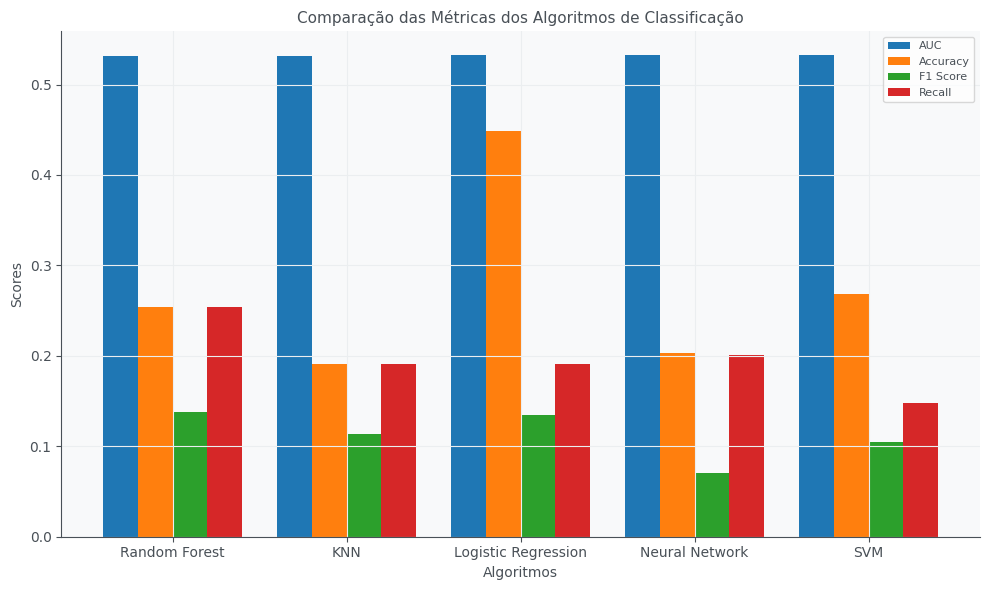

In [37]:
labels = ['Random Forest', 'KNN', 'Logistic Regression', 'Neural Network', 'SVM']
auc_scores = [mean_auc_rf, mean_auc_kn, mean_auc_lr, mean_auc_nn, mean_auc_svm]
accuracy_scores = [mean_accuracy_rf, mean_accuracy_kn, mean_accuracy_lr, mean_accuracy_nn, mean_accuracy_svm]
f1_scores = [mean_f1score_rf, mean_f1score_kn, mean_f1score_lr, mean_f1score_nn, mean_f1score_svm]
recall_scores = [mean_recall_rf, mean_recall_kn, mean_recall_lr, mean_recall_nn, mean_recall_svm]

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(labels))

ax.bar(x - 0.3, auc_scores, width=0.2, label='AUC')
ax.bar(x - 0.1, accuracy_scores, width=0.2, label='Accuracy')
ax.bar(x + 0.1, f1_scores, width=0.2, label='F1 Score')
ax.bar(x + 0.3, recall_scores, width=0.2, label='Recall')

ax.set_xlabel('Algoritmos')
ax.set_ylabel('Scores')
ax.set_title('Comparação das Métricas dos Algoritmos de Classificação')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()

### SMOTE

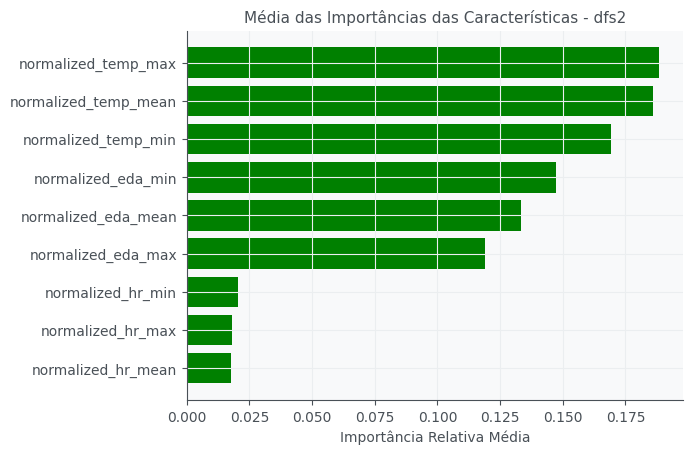


 Dataset: dfs2
auc = 0.5119134221698576
acc = 0.24053093150035554
f1 = 0.1377358221139742
recall = 0.24053093150035557


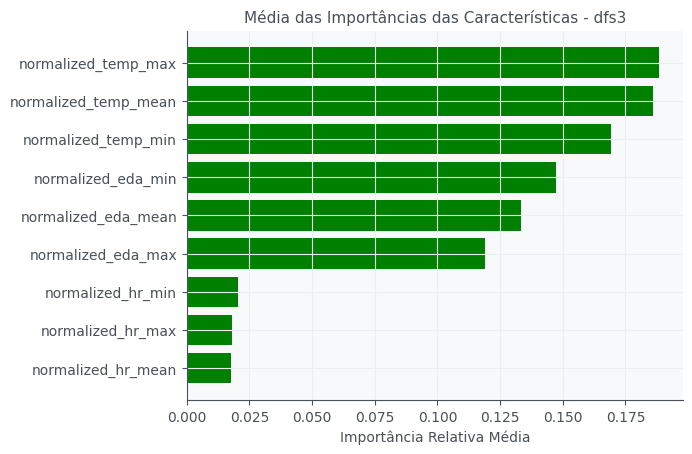


 Dataset: dfs3
auc = 0.4562684622756784
acc = 0.12647743136342485
f1 = 0.07153835773805002
recall = 0.12647743136342485


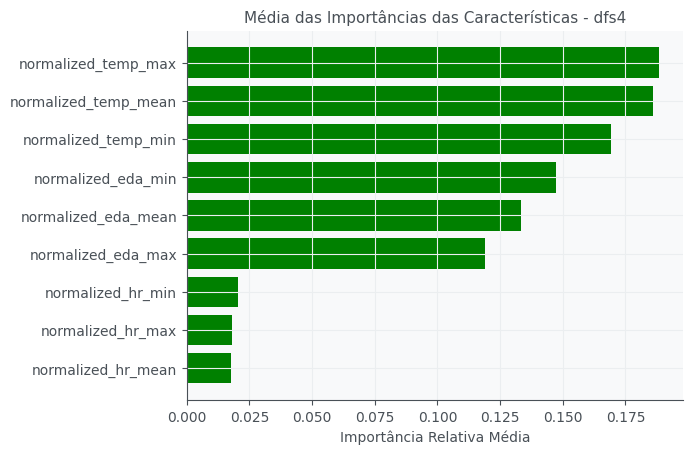


 Dataset: dfs4
auc = 0.49770216478538315
acc = 0.25031085604973696
f1 = 0.12893154416714997
recall = 0.25031085604973696


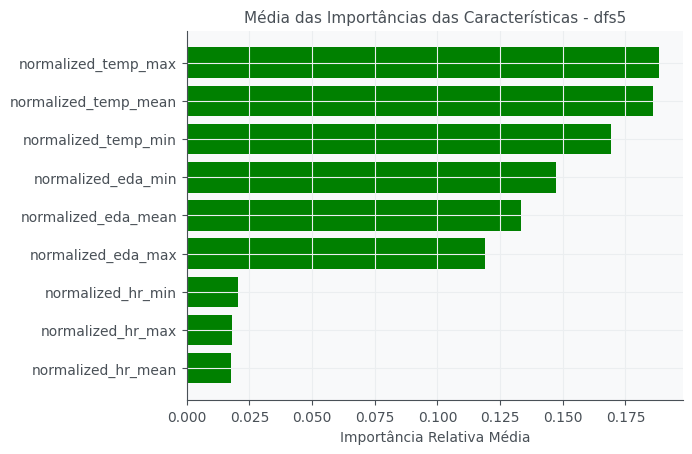


 Dataset: dfs5
auc = 0.5861773452146427
acc = 0.3364430244941427
f1 = 0.23697748335619448
recall = 0.33644302449414265


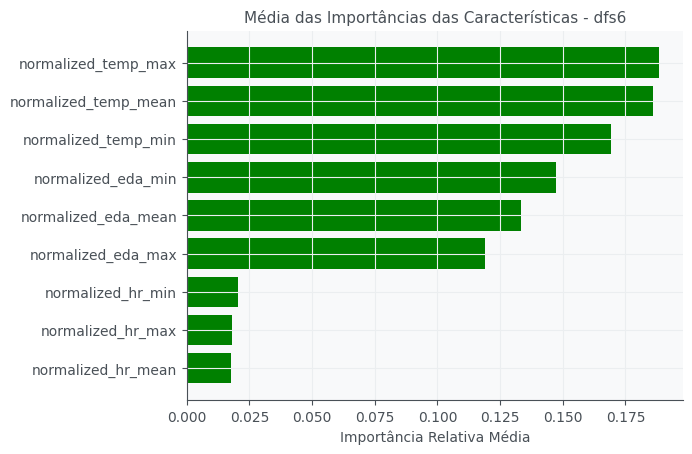


 Dataset: dfs6
auc = 0.5557838979848204
acc = 0.3231703419622883
f1 = 0.18622109401782722
recall = 0.3231703419622883


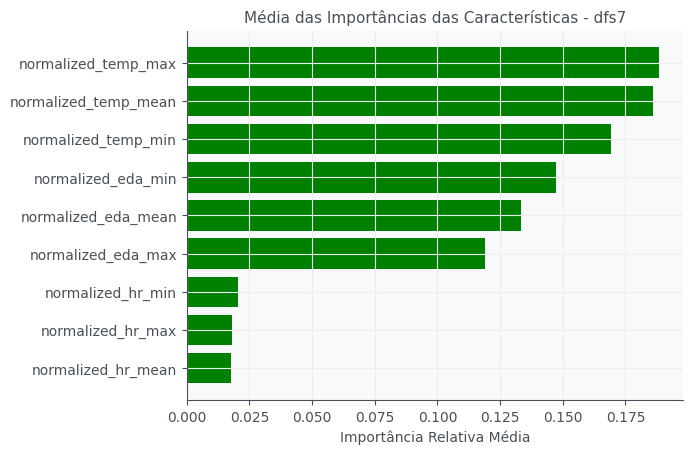


 Dataset: dfs7
auc = 0.5
acc = 0.2
f1 = 0.06666666666666668
recall = 0.2


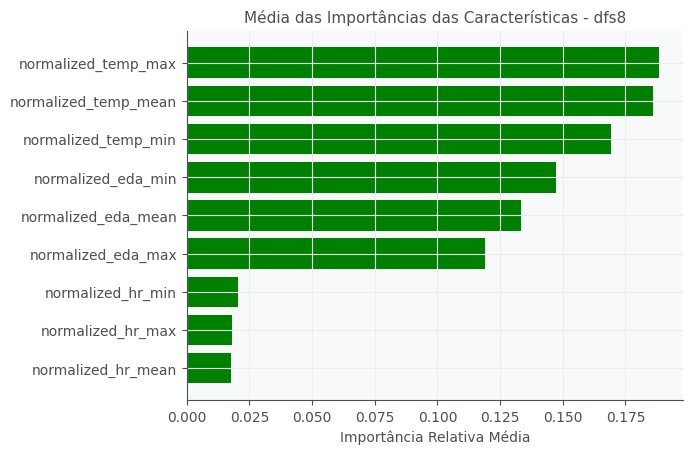


 Dataset: dfs8
auc = 0.49846178756476683
acc = 0.2
f1 = 0.06666666666666668
recall = 0.2


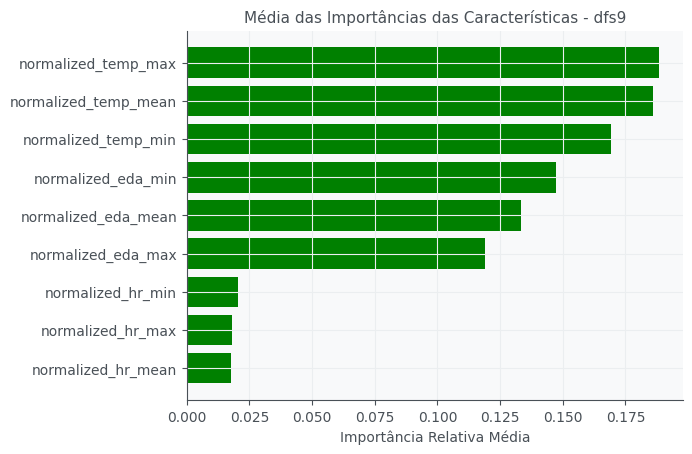


 Dataset: dfs9
auc = 0.5784971610780465
acc = 0.29143636983964516
f1 = 0.19772028411793635
recall = 0.29143636983964516


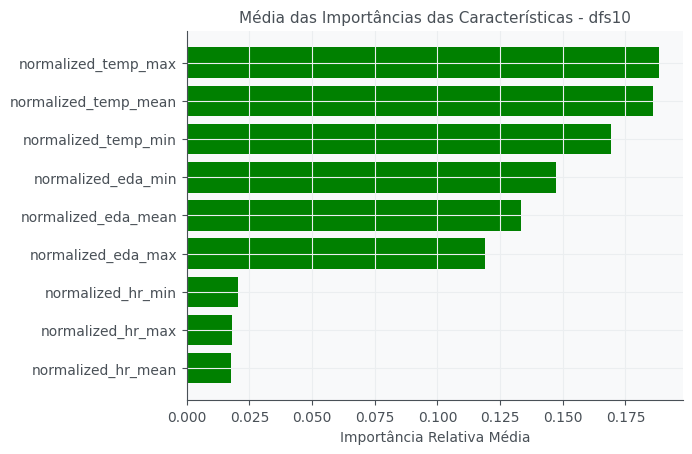


 Dataset: dfs10
auc = 0.5851280872776089
acc = 0.3345546430827543
f1 = 0.1893969898535185
recall = 0.3345546430827543


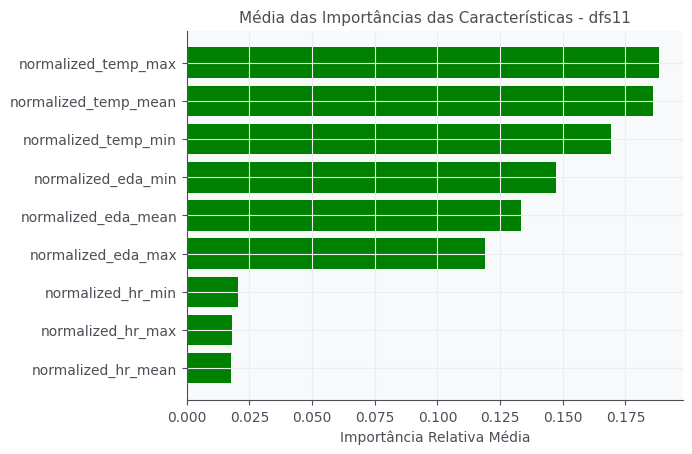


 Dataset: dfs11
auc = 0.5
acc = 0.2
f1 = 0.06666666666666668
recall = 0.2


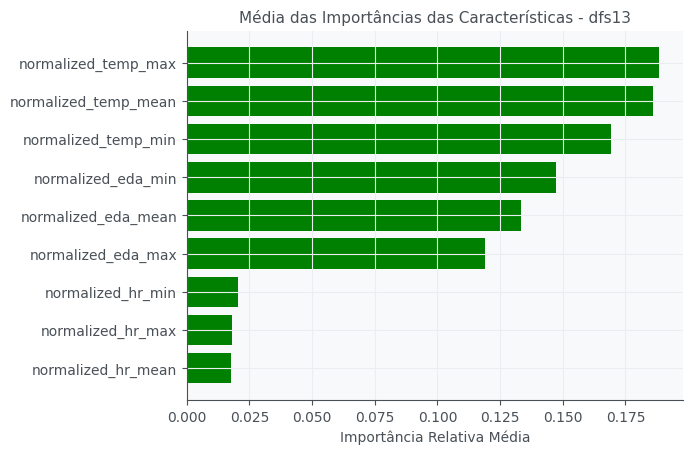


 Dataset: dfs13
auc = 0.5113598977350354
acc = 0.22292570845034465
f1 = 0.11345668964400649
recall = 0.22292570845034465


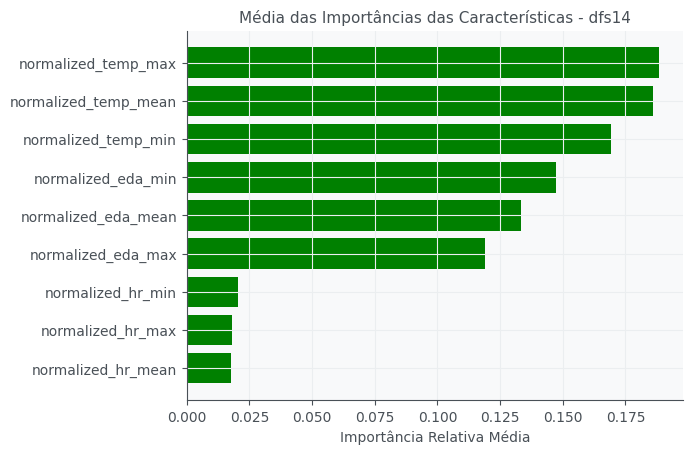


 Dataset: dfs14
auc = 0.5
acc = 0.1999312005503956
f1 = 0.06664755461269424
recall = 0.1999312005503956


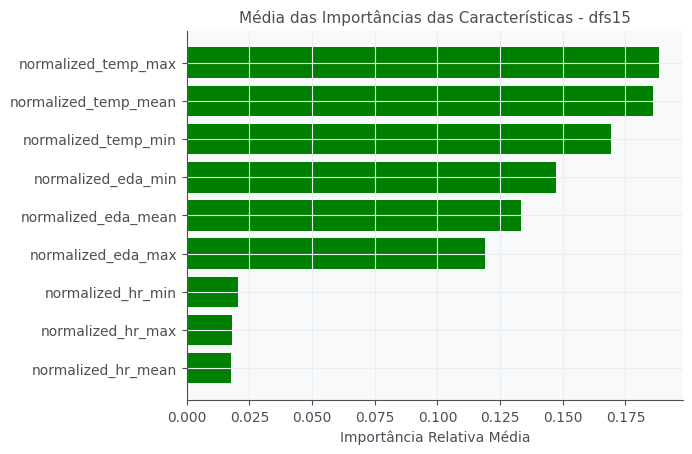


 Dataset: dfs15
auc = 0.558719973285396
acc = 0.30257289879931387
f1 = 0.21019823887024564
recall = 0.30257289879931387


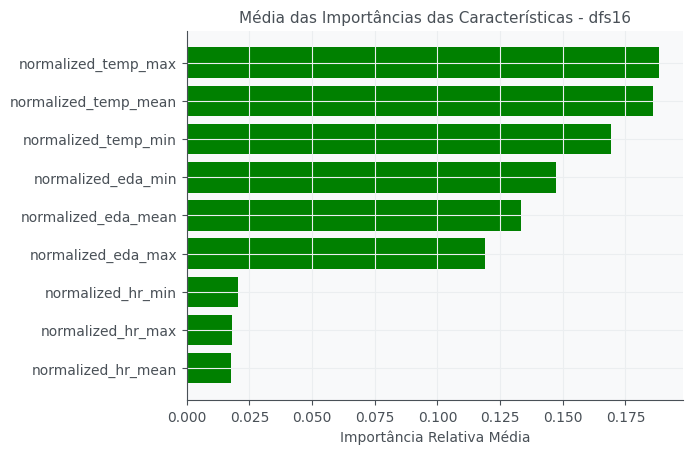


 Dataset: dfs16
auc = 0.62779667425709
acc = 0.38711175616835997
f1 = 0.26968161057212203
recall = 0.3871117561683599


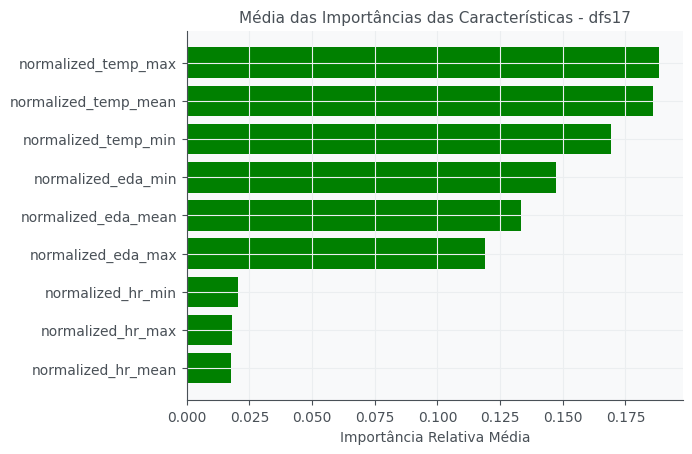


 Dataset: dfs17
auc = 0.5
acc = 0.2
f1 = 0.06666666666666668
recall = 0.2


In [38]:
auc_list = []
accuracy_list = []
f1score_list = []
recall_list = []

num_execucoes = 100

for i in list(range(2, 12)) + list(range(13, 18)):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)

    smote = SMOTE(random_state=47)
    X, y = smote.fit_resample(X, y)

    importancias_medias = np.zeros(X_train.shape[1])  # Lista para armazenar as importâncias médias das características
    for _ in range(num_execucoes):
        y_pred_rf = clf.predict(X)    
        importancias = clf.feature_importances_
        importancias_medias += importancias
    importancias_medias /= num_execucoes 
    
    f1score = f1_score(y, y_pred_rf, average='macro')
    recall = recall_score(y, y_pred_rf, average='macro')
    accuracy = accuracy_score(y, y_pred_rf)
    y_pred_proba_rf = clf.predict_proba(X_test)
    AUC = roc_auc_score(y_test, y_pred_proba_rf, multi_class='ovr')
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    auc_list.append(AUC)
    accuracy_list.append(accuracy)
    f1score_list.append(f1score)
    recall_list.append(recall)

    indices = np.argsort(importancias_medias)
    plt.title(f'Média das Importâncias das Características - {dataset_name}')
    j = 9  # Exibir as top 9 características mais importantes
    plt.barh(range(j), importancias_medias[indices][len(indices)-j:], color='g', align='center')
    plt.yticks(range(j), [X.columns[i] for i in indices[len(indices)-j:]])
    plt.xlabel('Importância Relativa Média')
    plt.show()
    
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)

mean_auc_rf = sum(auc_list) / len(auc_list)
mean_accuracy_rf = sum(accuracy_list) / len(accuracy_list)
mean_f1score_rf = sum(f1score_list) / len(f1score_list)
mean_recall_rf = sum(recall_list) / len(recall_list)


In [39]:
auc_list = []
accuracy_list = []
f1score_list = []
recall_list = []

for i in list(range(2, 12)) + list(range(13, 18)):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)

    smote = SMOTE(random_state=47)
    X, y = smote.fit_resample(X, y)
    
    y_pred_knn = k_nearest_neighbors.predict(X)
    f1score = f1_score(y, y_pred_knn, average='macro')
    recall = recall_score(y, y_pred_knn, average='macro')
    accuracy = accuracy_score(y, y_pred_knn)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    auc_list.append(AUC)
    accuracy_list.append(accuracy)
    f1score_list.append(f1score)
    recall_list.append(recall)

    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)

mean_auc_kn = sum(auc_list) / len(auc_list)
mean_accuracy_kn = sum(accuracy_list) / len(accuracy_list)
mean_f1score_kn = sum(f1score_list) / len(f1score_list)
mean_recall_kn = sum(recall_list) / len(recall_list)


 Dataset: dfs2
auc = 0.5119134221698576
acc = 0.20673145295093623
f1 = 0.15148697043157228
recall = 0.20673145295093623

 Dataset: dfs3
auc = 0.4562684622756784
acc = 0.2909725453699395
f1 = 0.1944692730793792
recall = 0.29097254536993955

 Dataset: dfs4
auc = 0.49770216478538315
acc = 0.21166905786704926
f1 = 0.09577795141905918
recall = 0.21166905786704926

 Dataset: dfs5
auc = 0.5861773452146427
acc = 0.22896698615548455
f1 = 0.12843579974911606
recall = 0.22896698615548455

 Dataset: dfs6
auc = 0.5557838979848204
acc = 0.13125599232981783
f1 = 0.0993458887229771
recall = 0.13125599232981783

 Dataset: dfs7
auc = 0.5
acc = 0.2860662951012027
f1 = 0.1717666694139949
recall = 0.2860662951012027

 Dataset: dfs8
auc = 0.49846178756476683
acc = 0.23076424870466322
f1 = 0.11413659003042306
recall = 0.23076424870466322

 Dataset: dfs9
auc = 0.5784971610780465
acc = 0.15789832821562608
f1 = 0.10196641490319594
recall = 0.15789832821562605

 Dataset: dfs10
auc = 0.5851280872776089
acc = 0.0

In [40]:
auc_list = []
accuracy_list = []
f1score_list = []
recall_list = []

for i in list(range(2, 12)) + list(range(13, 18)):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)

    smote = SMOTE(random_state=47)
    X, y = smote.fit_resample(X, y)
    
    y_pred_lr = logistic_regression.predict(X)
    f1score = f1_score(y, y_pred_lr, average='macro')
    recall = recall_score(y, y_pred_lr, average='macro')
    accuracy = accuracy_score(y, y_pred_lr)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    auc_list.append(AUC)
    accuracy_list.append(accuracy)
    f1score_list.append(f1score)
    recall_list.append(recall)

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)

mean_auc_lr = sum(auc_list) / len(auc_list)
mean_accuracy_lr = sum(accuracy_list) / len(accuracy_list)
mean_f1score_lr = sum(f1score_list) / len(f1score_list)
mean_recall_lr = sum(recall_list) / len(recall_list)




 Dataset: dfs2
auc = 0.5119134221698576
acc = 0.18748518606304812
f1 = 0.08446215669310386
recall = 0.18748518606304812

 Dataset: dfs3
auc = 0.4562684622756784
acc = 0.21205211726384365
f1 = 0.10783089038534058
recall = 0.21205211726384365

 Dataset: dfs4
auc = 0.49770216478538315
acc = 0.19311334289813487
f1 = 0.07762399077277969
recall = 0.19311334289813487

 Dataset: dfs5
auc = 0.5861773452146427
acc = 0.18666666666666668
f1 = 0.07158668572595465
recall = 0.18666666666666668

 Dataset: dfs6
auc = 0.5557838979848204
acc = 0.19734739533397253
f1 = 0.0779106078289121
recall = 0.19734739533397253

 Dataset: dfs7
auc = 0.5
acc = 0.2
f1 = 0.06666666666666668
recall = 0.2

 Dataset: dfs8
auc = 0.49846178756476683
acc = 0.1785621761658031
f1 = 0.07032434567694078
recall = 0.1785621761658031

 Dataset: dfs9
auc = 0.5784971610780465
acc = 0.17127260320709656
f1 = 0.06795722214701502
recall = 0.17127260320709656

 Dataset: dfs10
auc = 0.5851280872776089
acc = 0.18117498420720152
f1 = 0.07064

## teste e treino em datasets individuais

In [48]:
mean_auc = []
mean_acc = []
mean_f1 = []
mean_recall = []

for i in range(2, 18):
    if i == 12:
        continue

    dataset = globals()[f'dfs{i}']
    train_set = dataset.drop(columns='label_mean') 
    labels = np.array(dataset['label_mean'], dtype=int)

    X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.3, random_state=30)
    
    if len(y_train.shape) > 1:
        y_train = y_train.flatten()

    k_nearest_neighbors = KNeighborsClassifier(n_neighbors=5, metric="minkowski", weights="uniform")
    k_nearest_neighbors.fit(X_train, y_train.ravel())
    y_pred_knn = k_nearest_neighbors.predict(X_test)
    f1score_knn = f1_score(y_test, y_pred_knn, average='macro')
    recall_knn = recall_score(y_test, y_pred_knn, average='macro')
    accuracy_knn = accuracy_score(y_test, y_pred_knn)
    AUC_knn = roc_auc_score(y_test.ravel(), k_nearest_neighbors.predict_proba(X_test), multi_class='ovr')
    
    mean_f1.append(f1score_knn)
    mean_recall.append(recall_knn)
    mean_acc.append(accuracy_knn)
    mean_auc.append(AUC_knn)

final_metrics_knn = {
    'mean_auc': sum(mean_auc) / len(mean_auc),
    'mean_acc': sum(mean_acc) / len(mean_acc),
    'mean_f1': sum(mean_f1) / len(mean_f1),
    'mean_recall': sum(mean_recall) / len(mean_recall)
}

In [52]:
mean_auc_lr = []
mean_acc_lr = []
mean_f1_lr = []
mean_recall_lr = []

for i in range(2, 18):
    if i == 12:  
        continue
    
    dataset = globals()[f'dfs{i}']
    train_set = dataset.drop(columns='label_mean')
    labels = np.array(dataset['label_mean'], dtype=int)
    X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.3, random_state=30)

    logistic_regression = LogisticRegression(penalty="l2", C=1.0, max_iter=999)
    logistic_regression.fit(X_train, y_train.ravel())
    y_pred_lr = logistic_regression.predict(X_test)

    f1score_lr = f1_score(y_test, y_pred_lr, average='macro')
    recall_lr = recall_score(y_test, y_pred_lr, average='macro')
    accuracy_lr = accuracy_score(y_test, y_pred_lr)
    AUC_lr = roc_auc_score(y_test.ravel(), logistic_regression.predict_proba(X_test), multi_class='ovr')
    mean_f1_lr.append(f1score_lr)
    mean_recall_lr.append(recall_lr)
    mean_acc_lr.append(accuracy_lr)
    mean_auc_lr.append(AUC_lr)

final_metrics_lr = {
    'mean_auc': sum(mean_auc_lr) / len(mean_auc_lr),
    'mean_acc': sum(mean_acc_lr) / len(mean_acc_lr),
    'mean_f1': sum(mean_f1_lr) / len(mean_f1_lr),
    'mean_recall': sum(mean_recall_lr) / len(mean_recall_lr)
}



In [53]:
mean_auc_rf = []
mean_acc_rf = []
mean_f1_rf = []
mean_recall_rf = []

for i in range(2, 18):
    if i == 12:
        continue

    dataset = globals()[f'dfs{i}']
    train_set = dataset.drop(columns='label_mean')
    labels = np.array(dataset['label_mean'], dtype=int)
    X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.3, random_state=30)
    
    clf = RandomForestClassifier(n_estimators=100, max_depth=15)
    clf.fit(X_train, y_train.ravel())
    y_pred_rf = clf.predict(X_test)
    f1score_rf = f1_score(y_test, y_pred_rf, average='macro')
    recall_rf = recall_score(y_test, y_pred_rf, average='macro')
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    AUC_rf = roc_auc_score(y_test.ravel(), clf.predict_proba(X_test), multi_class='ovr')
    mean_f1_rf.append(f1score_rf)
    mean_recall_rf.append(recall_rf)
    mean_acc_rf.append(accuracy_rf)
    mean_auc_rf.append(AUC_rf)

final_metrics_rf = {
    'mean_auc': sum(mean_auc_rf) / len(mean_auc_rf),
    'mean_acc': sum(mean_acc_rf) / len(mean_acc_rf),
    'mean_f1': sum(mean_f1_rf) / len(mean_f1_rf),
    'mean_recall': sum(mean_recall_rf) / len(mean_recall_rf)
}


In [55]:
mean_auc_nn = []
mean_acc_nn = []
mean_f1_nn = []
mean_recall_nn = []

for i in range(2, 18):
    if i == 12:
        continue
    
    dataset = globals()[f'dfs{i}']
    train_set = dataset.drop(columns='label_mean')
    labels = np.array(dataset['label_mean'], dtype=int)
    X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.3, random_state=30)

    neural_network = MLPClassifier(hidden_layer_sizes=(100,), activation="relu", solver="adam", max_iter=999)
    neural_network.fit(X_train, y_train.ravel())
    y_pred_nn = neural_network.predict(X_test)

    f1score_nn = f1_score(y_test, y_pred_nn, average='macro')
    recall_nn = recall_score(y_test, y_pred_nn, average='macro')
    accuracy_nn = accuracy_score(y_test, y_pred_nn)
    AUC_nn = roc_auc_score(y_test.ravel(), neural_network.predict_proba(X_test), multi_class='ovr')
    mean_f1_nn.append(f1score_nn)
    mean_recall_nn.append(recall_nn)
    mean_acc_nn.append(accuracy_nn)
    mean_auc_nn.append(AUC_nn)

final_metrics_nn = {
    'mean_auc': sum(mean_auc_nn) / len(mean_auc_nn),
    'mean_acc': sum(mean_acc_nn) / len(mean_acc_nn),
    'mean_f1': sum(mean_f1_nn) / len(mean_f1_nn),
    'mean_recall': sum(mean_recall_nn) / len(mean_recall_nn)
}


c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (999) reached and the opti

In [57]:
mean_auc_svm = []
mean_acc_svm = []
mean_f1_svm = []
mean_recall_svm = []

for i in range(2, 18):
    if i == 12:  
        continue

    dataset = globals()[f'dfs{i}']
    train_set = dataset.drop(columns='label_mean')
    labels = np.array(dataset['label_mean'], dtype=int)
    X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.3, random_state=30)

    support_vector_machine = SVC(C=1.0, gamma=0.1, kernel="linear", tol=0.001, max_iter=9999, probability=True)
    support_vector_machine.fit(X_train, y_train.ravel())
    y_pred_svm = support_vector_machine.predict(X_test)
    
    f1score_svm = f1_score(y_test, y_pred_svm, average='macro')
    recall_svm = recall_score(y_test, y_pred_svm, average='macro')
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    AUC_svm = roc_auc_score(y_test.ravel(), support_vector_machine.predict_proba(X_test), multi_class='ovr')
    mean_f1_svm.append(f1score_svm)
    mean_recall_svm.append(recall_svm)
    mean_acc_svm.append(accuracy_svm)
    mean_auc_svm.append(AUC_svm)

final_metrics_svm = {
    'mean_auc': sum(mean_auc_svm) / len(mean_auc_svm),
    'mean_acc': sum(mean_acc_svm) / len(mean_acc_svm),
    'mean_f1': sum(mean_f1_svm) / len(mean_f1_svm),
    'mean_recall': sum(mean_recall_svm) / len(mean_recall_svm)
}


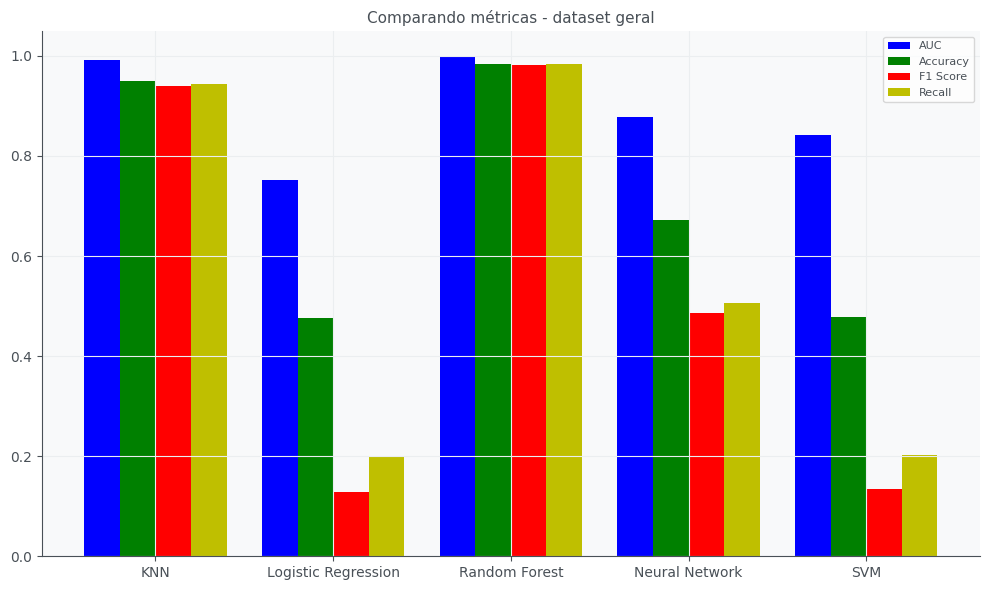

In [59]:
labels = ['KNN', 'Logistic Regression', 'Random Forest', 'Neural Network', 'SVM']

auc_scores = [final_metrics_knn['mean_auc'], final_metrics_lr['mean_auc'], final_metrics_rf['mean_auc'], final_metrics_nn['mean_auc'], final_metrics_svm['mean_auc']]
accuracy_scores = [final_metrics_knn['mean_acc'], final_metrics_lr['mean_acc'], final_metrics_rf['mean_acc'], final_metrics_nn['mean_acc'], final_metrics_svm['mean_acc']]
f1_scores = [final_metrics_knn['mean_f1'], final_metrics_lr['mean_f1'], final_metrics_rf['mean_f1'], final_metrics_nn['mean_f1'], final_metrics_svm['mean_f1']]
recall_scores = [final_metrics_knn['mean_recall'], final_metrics_lr['mean_recall'], final_metrics_rf['mean_recall'], final_metrics_nn['mean_recall'], final_metrics_svm['mean_recall']]

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(labels))

ax.bar(x - 0.3, auc_scores, width=0.2, label='AUC', color='b')
ax.bar(x - 0.1, accuracy_scores, width=0.2, label='Accuracy', color='g')
ax.bar(x + 0.1, f1_scores, width=0.2, label='F1 Score', color='r')
ax.bar(x + 0.3, recall_scores, width=0.2, label='Recall', color='y')

ax.set_title('Comparando métricas - dataset geral')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()

## rf com diferentes porcentagem no dataset geral

#### 10%

#### 20%

#### 30%

#### 40%

#### 50%